# Setup

In [1]:
# To write a Python 2/3 compatible codebase, the first step is to add this line to the top of each module
from __future__ import division, print_function, unicode_literals

# Import necessary libraries and specify that graphs should be plotted inline.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import ListedColormap
import seaborn as sns
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

######################################### Load Libraries and Modules for model evaluation metrics #########################################
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, cohen_kappa_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import confusion_matrix
import itertools
############################### Import Libraries & Modules for Model Building & Validation #################################
#from sklearn import linear_model
#from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn import neighbors, datasets
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler      # Standardize features by removing the mean and scaling to unit variance

np.random.seed(42) # Ensure reproducability
################################################## Load Data ##################################################

df = pd.read_csv("/Users/baixiao/Desktop/bank-additional-full.csv")

print(list(df.columns.values))
#print(df.isnull().values.any())

['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'y']


In [2]:
print(df.shape)
df.head()

(41188, 21)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


# Data Understanding

In [3]:
#Drop "duration"   #SOURCE - https://stackoverflow.com/questions/44931834/pandas-drop-function-error-label-not-contained-in-axis?noredirect=1&lq=1
if 'duration' in df:
    df = df.drop(['duration'], axis=1)

#Check if there are any null values
check = df.isnull().values.any()  #no false values SOURCE - https://chartio.com/resources/tutorials/how-to-check-if-any-value-is-nan-in-a-pandas-dataframe/
print('Are there null values? '+ str(check) )
print(df.shape)

# Retrieving Attributes (X)
X = df.iloc[:, 0:19]
features = []   
for col in X.columns:     #SOURCE - https://www.geeksforgeeks.org/how-to-get-column-names-in-pandas-dataframe/
    features.append(col)  #list of features to use in our tree from the dataset
print("X:")
print(X.head())
    
# Retriving Target Variable (y)
y = df.iloc[:,19] # grab target column
print("y:")
print(y.head())

Are there null values? False
(41188, 20)
X:
   age        job  marital    education  default housing loan    contact  \
0   56  housemaid  married     basic.4y       no      no   no  telephone   
1   57   services  married  high.school  unknown      no   no  telephone   
2   37   services  married  high.school       no     yes   no  telephone   
3   40     admin.  married     basic.6y       no      no   no  telephone   
4   56   services  married  high.school       no      no  yes  telephone   

  month day_of_week  campaign  pdays  previous     poutcome  emp.var.rate  \
0   may         mon         1    999         0  nonexistent           1.1   
1   may         mon         1    999         0  nonexistent           1.1   
2   may         mon         1    999         0  nonexistent           1.1   
3   may         mon         1    999         0  nonexistent           1.1   
4   may         mon         1    999         0  nonexistent           1.1   

   cons.price.idx  cons.conf.idx  eu

The frequency of instances per class is:  {'no': 36548, 'yes': 4640}  where YES means the customer deposited, and NO means the customer did not deposit.
The Percentages per class: No: 0.89; Yes: 0.11


Text(0.5, 1.0, 'Distribution of Target Variable')

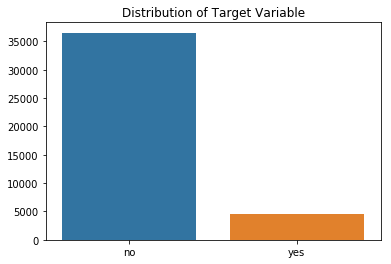

In [4]:
# Exploring Target Variable
unique, counts = np.unique(y, return_counts=True) # 2 distinct classes relatively balanced
print("The frequency of instances per class is: " , dict(zip(unique, counts)), " where YES means the customer deposited, and NO means the customer did not deposit.")
print("The Percentages per class:", "No: %.2f;" % (counts[0]/(counts[0]+counts[1])), "Yes: %.2f" % (counts[1]/(counts[0]+counts[1])))
sns.barplot(unique, counts)
plt.title("Distribution of Target Variable")

Conclusion: need data rebalance 

In [5]:
# [IMPORTANT:] categorical and numeric feature lists
numeric =['age' , 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed' ]
categorical = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']

#### Numeric features exploration

In [6]:
#Info about the quantitative data
print("Description of Quantitative Values")
print(df.describe())

Description of Quantitative Values
               age      campaign         pdays      previous  emp.var.rate  \
count  41188.00000  41188.000000  41188.000000  41188.000000  41188.000000   
mean      40.02406      2.567593    962.475454      0.172963      0.081886   
std       10.42125      2.770014    186.910907      0.494901      1.570960   
min       17.00000      1.000000      0.000000      0.000000     -3.400000   
25%       32.00000      1.000000    999.000000      0.000000     -1.800000   
50%       38.00000      2.000000    999.000000      0.000000      1.100000   
75%       47.00000      3.000000    999.000000      0.000000      1.400000   
max       98.00000     56.000000    999.000000      7.000000      1.400000   

       cons.price.idx  cons.conf.idx     euribor3m   nr.employed  
count    41188.000000   41188.000000  41188.000000  41188.000000  
mean        93.575664     -40.502600      3.621291   5167.035911  
std          0.578840       4.628198      1.734447     72.251

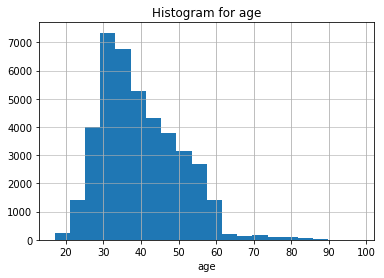

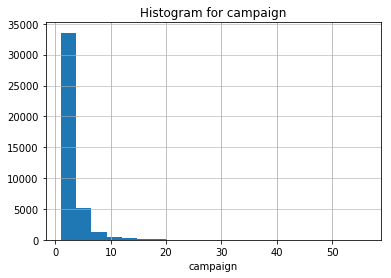

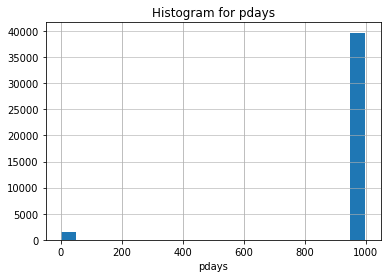

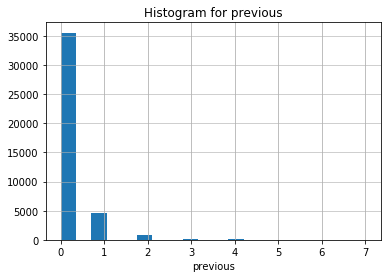

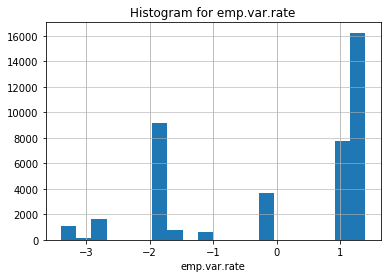

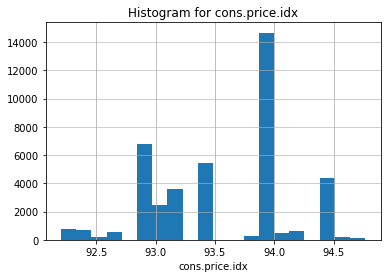

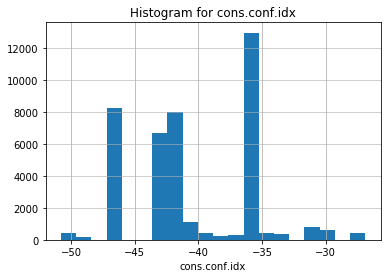

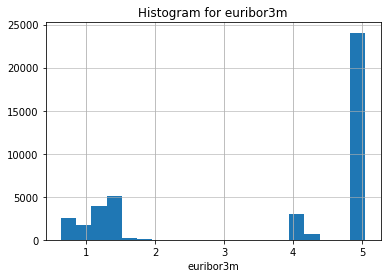

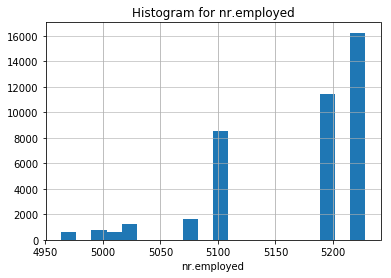

In [7]:
#plot hist for each columns
for i in numeric:
    dist = df[i]
    dist.hist(grid=True, bins=20)
    plt.title('Histogram for ' + str(i))
    plt.xlabel(i)
    plt.grid(axis='y', alpha=0.75) 
    plt.show()


Observation: The vast majority people have not been contacted in Previous campaigns.
Thinking: create new variable indicate indicating "Contacted in Previous or Not?"

#### Categorical Feature Exploration

In [8]:
#Info about the qualitative data
print("\n")
print("Description of Quantitative Values")
for i in categorical:
    print("\n")
    print("Description of " + "'" + i + "'" )
    cat = df[i]
    value_count = cat.value_counts()
    print(value_count)
    if 'unknown' in value_count.index:
        print("Percentage of 'unknown': %.3f" % (value_count['unknown']/sum(value_count)))



Description of Quantitative Values


Description of 'job'
admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: job, dtype: int64
Percentage of 'unknown': 0.008


Description of 'marital'
married     24928
single      11568
divorced     4612
unknown        80
Name: marital, dtype: int64
Percentage of 'unknown': 0.002


Description of 'education'
university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
unknown                 1731
illiterate                18
Name: education, dtype: int64
Percentage of 'unknown': 0.042


Description of 'default'
no         32588
unknown     8597
yes            3
Name: default, dtype: int64
Percentage of 'unknown'

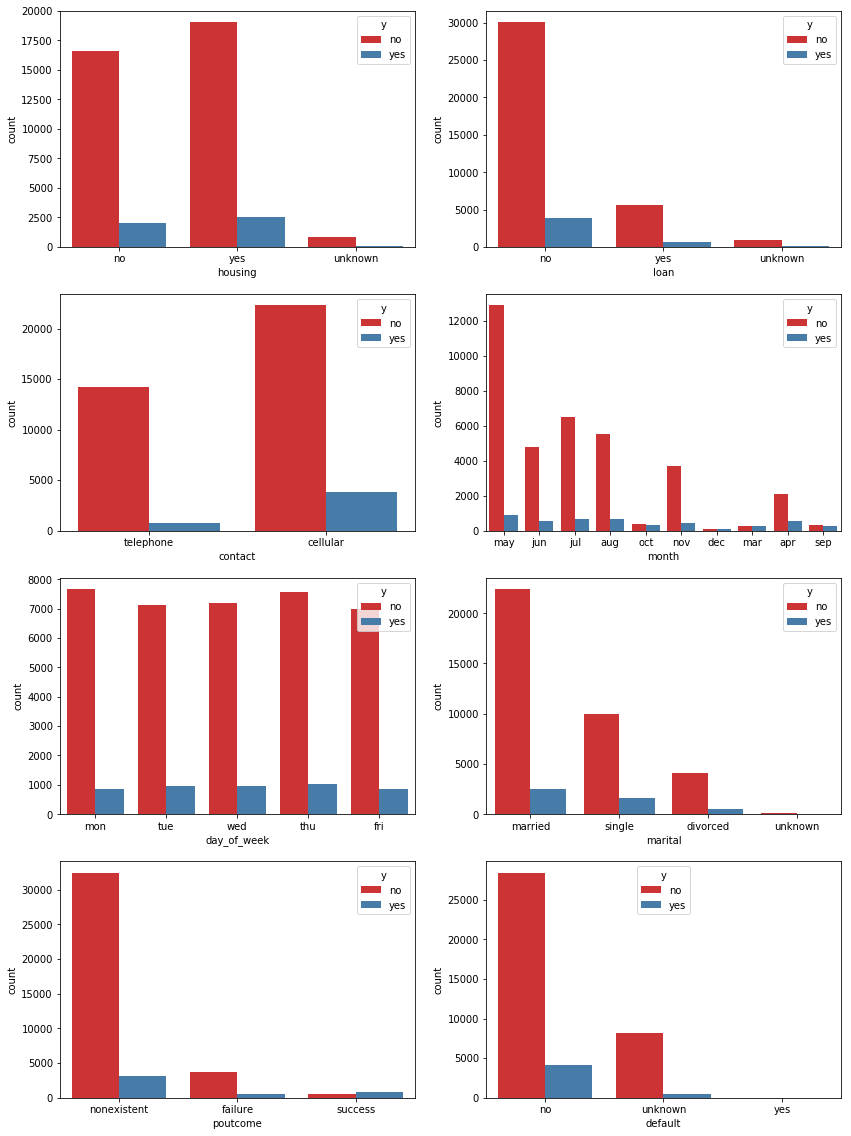

In [9]:
#barplots showing the frequency of each category separated by label
plt.figure(figsize=[14,20])
plt.subplot(4,2,1)
sns.countplot(x='housing', hue='y', data=df,palette="Set1")
plt.subplot(4,2,2)
sns.countplot(x='loan', hue='y', data=df,palette="Set1")
plt.subplot(4,2,3)
sns.countplot(x='contact', hue='y', data=df,palette="Set1")
plt.subplot(4,2,4)
sns.countplot(x='month', hue='y', data=df,palette="Set1")
plt.subplot(4,2,5)
sns.countplot(x='day_of_week', hue='y', data=df,palette="Set1")
plt.subplot(4,2,6)
sns.countplot(x='marital', hue='y', data=df,palette="Set1")
plt.subplot(4,2,7)
sns.countplot(x='poutcome', hue='y', data=df,palette="Set1")
plt.subplot(4,2,8)
sns.countplot(x='default', hue='y', data=df,palette="Set1")
plt.show()


#plt.subplot(4,2,9)
#sns.countplot(x='education', hue='y', data=df, palette="Set1")

# plt.subplot(4,2,10)
# sns.countplot(x='job', hue='y', data=df,palette="Set2")

Observation & Conclusion: 
"default" column has more than 20% 'unknown's, and extreme data imbalance issue between "yes" and "no" in this column.
So, discard this column.

Based on previous observation from statistics and graph, clean the data:<br>
-remove "default" feature<br>
-try deleting any observation with 'unknown' in columns (and see how much data is left)<br>
-encoding textual categorical variables into numbers<br>
-[not using] data resampling(rebalancing) technique<br>

## Data Preparation

### Note: For "Data Preparation" part, see the remaining Jupyter Notebooks in the folder.

create Candidate New Variables possible for later use in model building:<br>
- create dummy variables<br>
- logging <br>
- square root <br>
- cube root <br>
...

#### Variable Correlation Exploration

encoded variables

In [10]:
#read in the "X_encoded" and "y" encoded from external files
X_encoded = pd.read_csv("/Users/baixiao/Desktop/X_encoded.csv")
y = pd.read_csv("/Users/baixiao/Desktop/y.csv")
print(X_encoded.head())
print(y.head())
print(X_encoded.shape)
print(y.shape)

   age  campaign  pdays  previous  emp.var.rate  cons.price.idx  \
0   56         1     -1         0           1.1          93.994   
1   57         1     -1         0           1.1          93.994   
2   37         1     -1         0           1.1          93.994   
3   40         1     -1         0           1.1          93.994   
4   56         1     -1         0           1.1          93.994   

   cons.conf.idx  euribor3m  nr.employed  job_encoded  marital_encoded  \
0          -36.4      4.857       5191.0            3                1   
1          -36.4      4.857       5191.0            7                1   
2          -36.4      4.857       5191.0            7                1   
3          -36.4      4.857       5191.0            0                1   
4          -36.4      4.857       5191.0            7                1   

   education_encoded  housing_encoded  loan_encoded  contact_encoded  \
0                  0                0             0                1   
1       

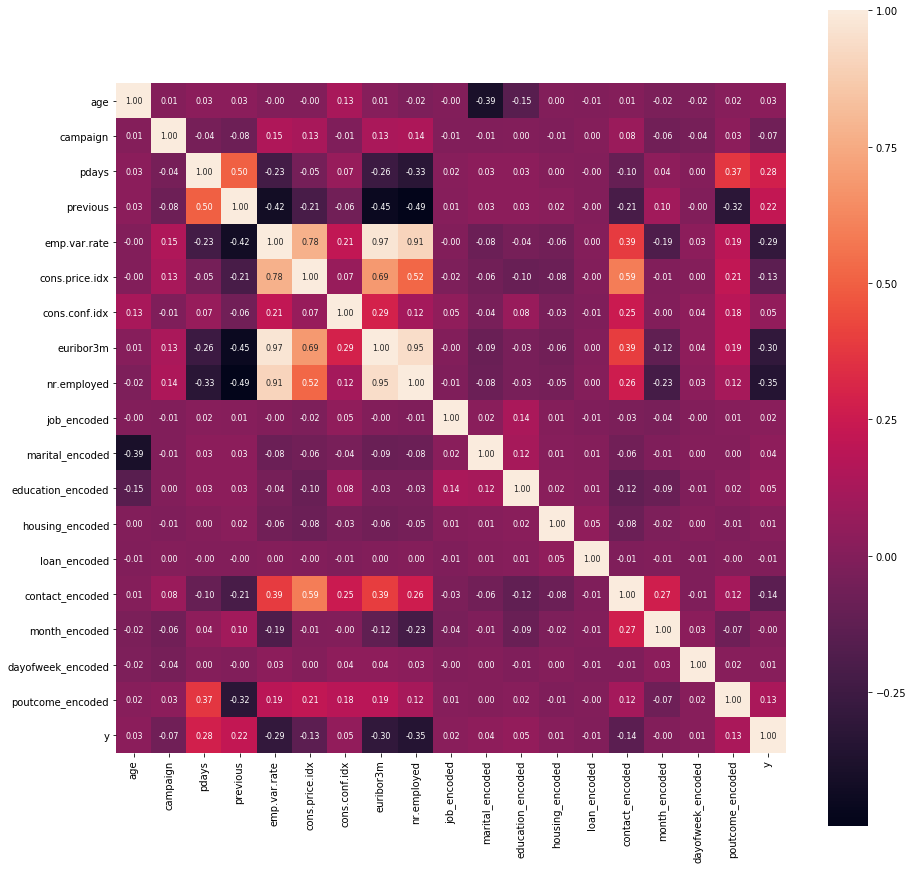

In [13]:
#Correlation among ALL VARIABLES (including numeric and categorical)--using "X_encoded"
mydat = pd.concat([X_encoded, y], axis=1)

cm = np.corrcoef(mydat.values.T)

plt.figure(figsize=(15,15))

sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size':8}, 
           yticklabels=np.append(X_encoded.columns, "y"), xticklabels=np.append(X_encoded.columns, "y"))

dummy variables

In [14]:
#read in the "X_dummy_unbalanced" and "y" encoded from external files
X_dummy_unbalanced = pd.read_csv("/Users/baixiao/Desktop/X_dummy_unbalanced.csv")
y = pd.read_csv("/Users/baixiao/Desktop/y.csv")
print(X_dummy_unbalanced.head())
print(y.head())
print(X_dummy_unbalanced.shape)
print(y.shape)

   age  campaign  pdays  previous  emp.var.rate  cons.price.idx  \
0   56         1     -1         0           1.1          93.994   
1   57         1     -1         0           1.1          93.994   
2   37         1     -1         0           1.1          93.994   
3   40         1     -1         0           1.1          93.994   
4   56         1     -1         0           1.1          93.994   

   cons.conf.idx  euribor3m  nr.employed  housing     ...       mar  may  nov  \
0          -36.4      4.857       5191.0        0     ...         0    1    0   
1          -36.4      4.857       5191.0        0     ...         0    1    0   
2          -36.4      4.857       5191.0        1     ...         0    1    0   
3          -36.4      4.857       5191.0        0     ...         0    1    0   
4          -36.4      4.857       5191.0        0     ...         0    1    0   

   oct  fri  mon  thu  tue  failure  nonexistent  
0    0    0    1    0    0        0            1  
1    0  

In [15]:
#Correlation among ALL VARIABLES (including numeric and categorical)--using "X_encoded"
mydat = pd.concat([X_dummy_unbalanced.iloc[:, 9:], y], axis=1)

corr = mydat.corr()
corr
#corr.style.background_gradient(cmap='coolwarm').set_precision(3)

,housing,loan,admin.,blue-collar,entrepreneur,housemaid,management,retired,self-employed,services,...,may,nov,oct,fri,mon,thu,tue,failure,nonexistent,y
housing,1.000000,0.045077,0.010444,-0.012680,0.004600,-0.007298,-0.009337,-0.000664,0.000614,-0.004679,...,-0.022443,0.032703,0.003394,-0.015131,0.012786,0.011809,-0.010473,0.020749,-0.024586,0.009996
loan,0.045077,1.000000,0.021159,-0.005318,-0.005413,-0.002631,-0.001135,-0.008961,-0.007891,-0.000242,...,0.000390,-0.004135,-0.010349,0.007997,0.006027,-0.002162,-0.009746,0.000410,0.001042,-0.005603
admin.,0.010444,0.021159,1.000000,-0.318157,-0.113767,-0.096432,-0.164201,-0.122870,-0.113289,-0.194365,...,-0.056891,0.004179,0.008603,0.010362,-0.000975,-0.004902,-0.000413,0.002027,-0.015921,0.033488
blue-collar,-0.012680,-0.005318,-0.318157,1.000000,-0.103113,-0.087401,-0.148824,-0.111363,-0.102680,-0.176163,...,0.139399,-0.060640,-0.048447,0.001783,-0.010403,-0.007712,-0.006231,-0.007630,0.037615,-0.071404
entrepreneur,0.004600,-0.005413,-0.113767,-0.103113,1.000000,-0.031253,-0.053217,-0.039821,-0.036716,-0.062993,...,-0.001483,0.056181,-0.011321,-0.001763,0.007354,0.005596,-0.007484,0.001875,0.006258,-0.015897
housemaid,-0.007298,-0.002631,-0.096432,-0.087401,-0.031253,1.000000,-0.045108,-0.033754,-0.031122,-0.053394,...,-0.018586,-0.009591,0.001258,-0.009872,0.005055,-0.008811,0.010366,-0.018766,0.014292,-0.006232
management,-0.009337,-0.001135,-0.164201,-0.148824,-0.053217,-0.045108,1.000000,-0.057475,-0.052993,-0.090918,...,-0.016061,0.086620,-0.000005,-0.006563,0.008915,-0.007345,0.004196,0.007438,-0.006408,0.000090
retired,-0.000664,-0.008961,-0.122870,-0.111363,-0.039821,-0.033754,-0.057475,1.000000,-0.039654,-0.068033,...,-0.061470,-0.013792,0.090775,0.001050,-0.000280,-0.012709,0.012441,0.019780,-0.053594,0.089646
self-employed,0.000614,-0.007891,-0.113289,-0.102680,-0.036716,-0.031122,-0.052993,-0.039654,1.000000,-0.062728,...,-0.016306,0.025537,-0.003534,0.004777,0.005033,0.013735,-0.009246,-0.001322,0.006908,-0.001888
services,-0.004679,-0.000242,-0.194365,-0.176163,-0.062993,-0.053394,-0.090918,-0.068033,-0.062728,1.000000,...,0.060042,-0.020934,-0.021051,-0.001783,0.005617,0.002956,0.000027,0.010624,0.004440,-0.032759


#### Exploring Feature Transformations

In [16]:
X = pd.read_csv("/Users/baixiao/Desktop/X_balance.csv")
y = pd.read_csv("/Users/baixiao/Desktop/y_balance.csv")  

QQplot of age


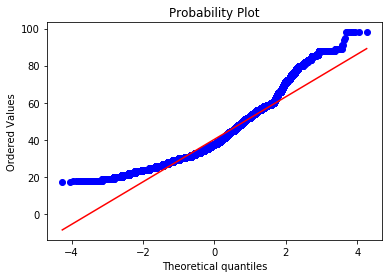

0.9988905745380051
QQplot of age (log)


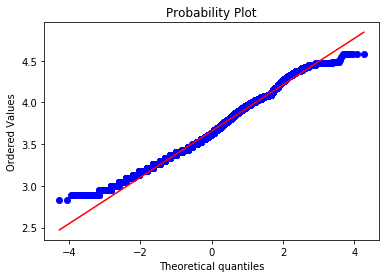

0.28035883480967205
QQplot of age (sqrt)


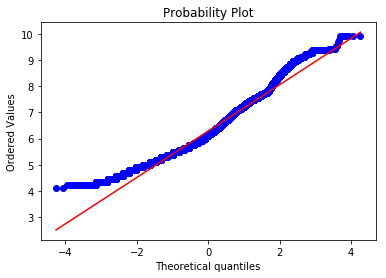

0.6258668265924762
QQplot of age (cubert)


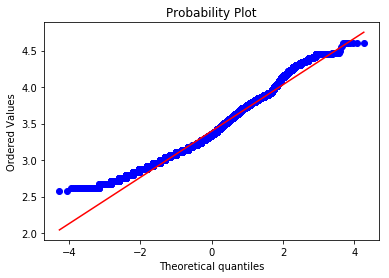

0.5084584142698017
QQplot of campaign


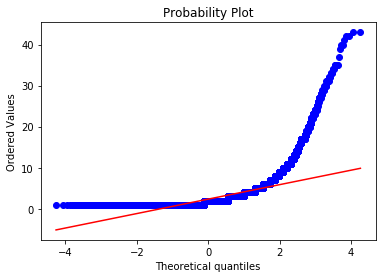

4.93464066852659
QQplot of campaign (log)


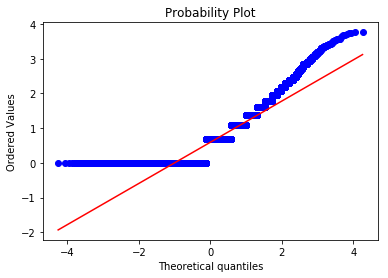

0.9358595105489252
QQplot of campaign (sqrt)


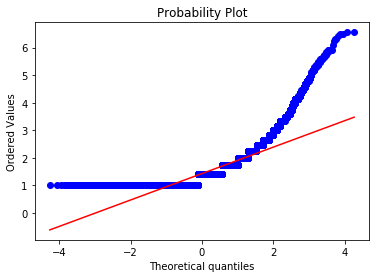

2.155538027525771
QQplot of campaign (cubert)


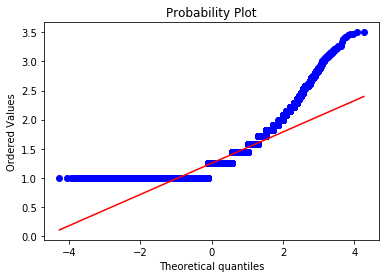

1.631865772268322
QQplot of pdays


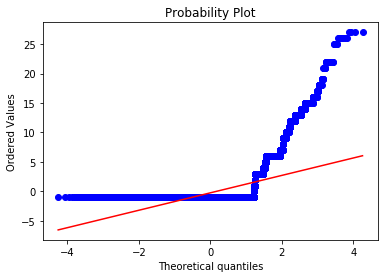

4.033659070849569
pdayslog graph will not work
pdayssqrt graph will not work
pdayscubert graph will not work
QQplot of previous


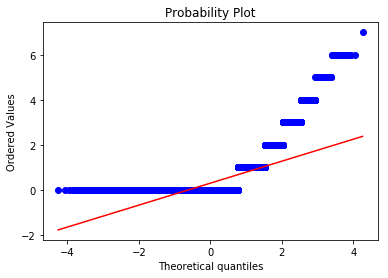

2.862043167736751
previouslog graph will not work
QQplot of previous (sqrt)


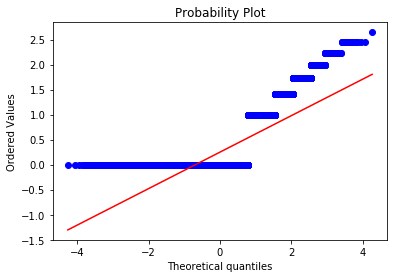

1.67984251765876
QQplot of previous (cubert)


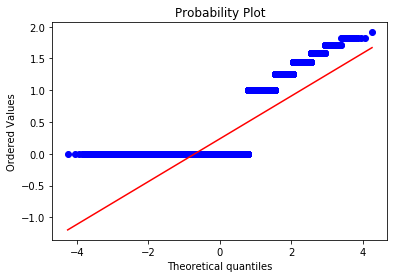

1.5005619879674004
QQplot of emp.var.rate


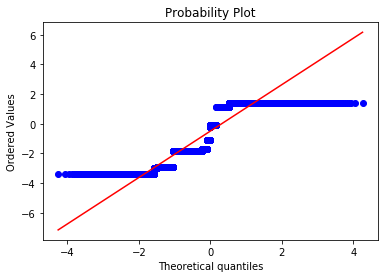

-0.1528190433781906
emp.var.ratelog graph will not work
emp.var.ratesqrt graph will not work
emp.var.ratecubert graph will not work
QQplot of cons.price.idx


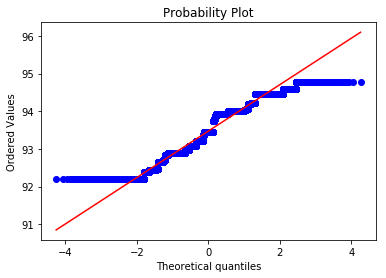

-0.09726198364667638
QQplot of cons.price.idx (log)


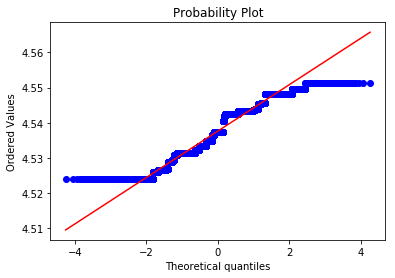

-0.10770917953764846
QQplot of cons.price.idx (sqrt)


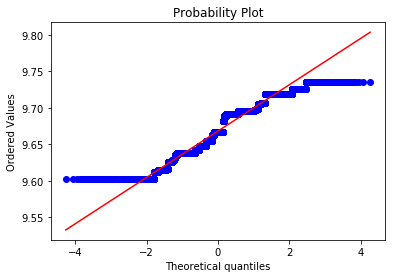

-0.10248309845266634
QQplot of cons.price.idx (cubert)


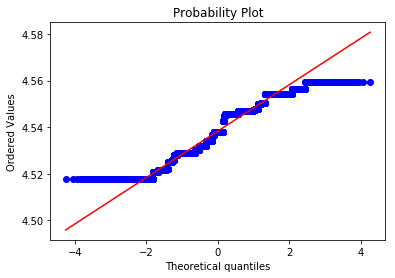

-0.10422457011491884
QQplot of cons.conf.idx


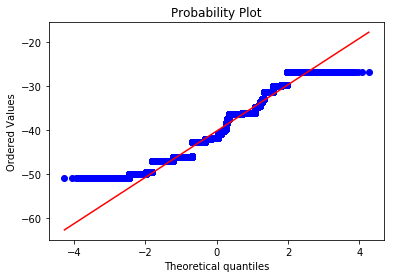

0.3488951118146305
cons.conf.idxlog graph will not work
cons.conf.idxsqrt graph will not work
cons.conf.idxcubert graph will not work
QQplot of euribor3m


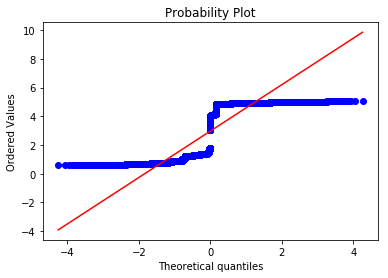

-0.028566476282109912
QQplot of euribor3m (log)


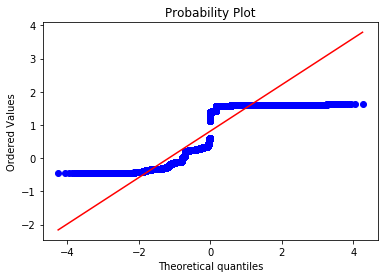

-0.20506880689083443
QQplot of euribor3m (sqrt)


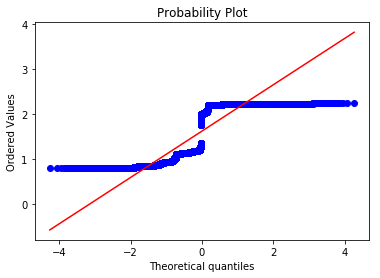

-0.09225496179306715
QQplot of euribor3m (cubert)


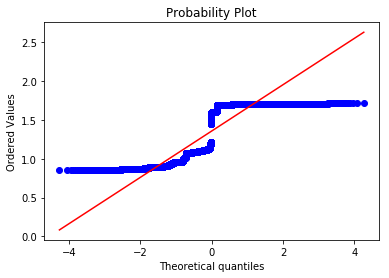

-0.12305852955953021
QQplot of nr.employed


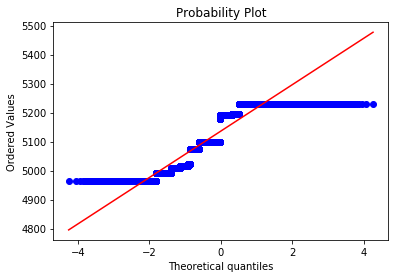

-0.436213809425052
QQplot of nr.employed (log)


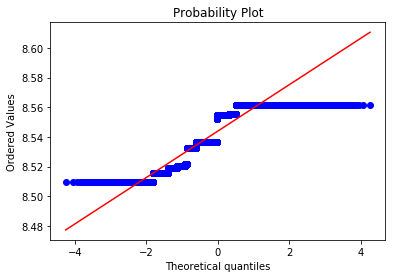

-0.45240715893871686
QQplot of nr.employed (sqrt)


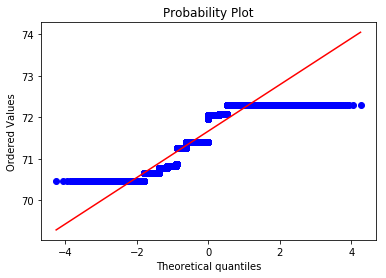

-0.44428238511650975
QQplot of nr.employed (cubert)


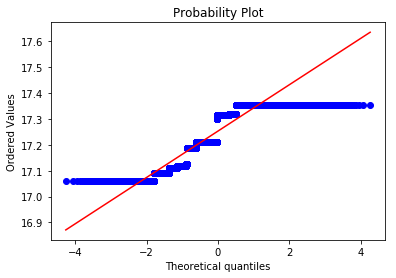

-0.44698440744377776
QQplot of job_encoded


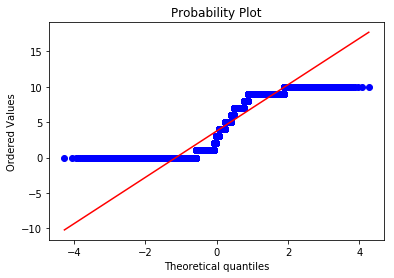

0.39763809027860214
job_encodedlog graph will not work
QQplot of job_encoded (sqrt)


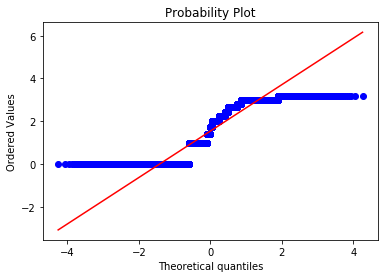

-0.10861458386329938
QQplot of job_encoded (cubert)


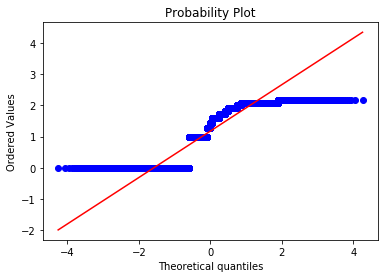

-0.42046874253809724
QQplot of marital_encoded


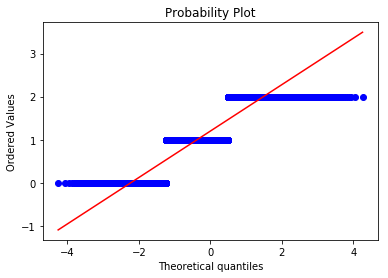

-0.1488878044510951
marital_encodedlog graph will not work
QQplot of marital_encoded (sqrt)


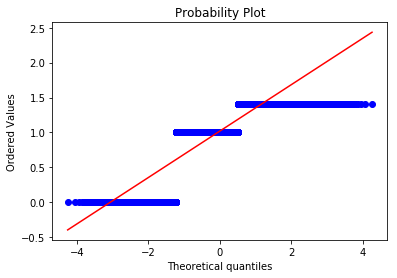

-1.482147310317928
QQplot of marital_encoded (cubert)


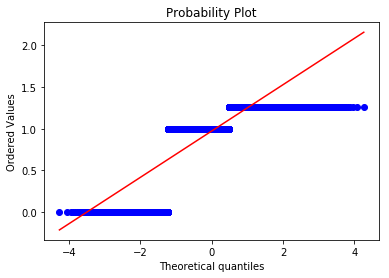

-1.9963055857370917
QQplot of education_encoded


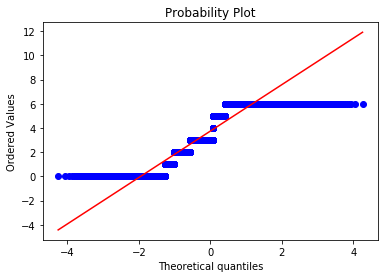

-0.34507456807422504
education_encodedlog graph will not work
QQplot of education_encoded (sqrt)


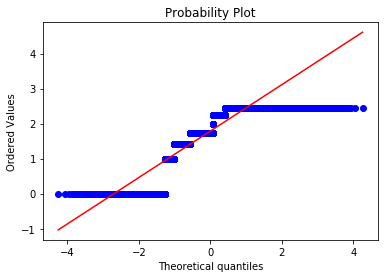

-1.224739424655726
QQplot of education_encoded (cubert)


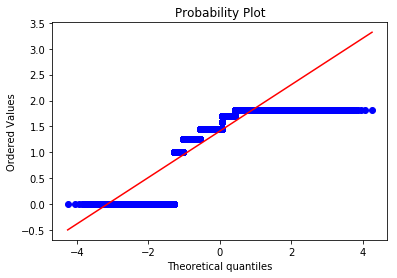

-1.759541211364812
QQplot of housing_encoded


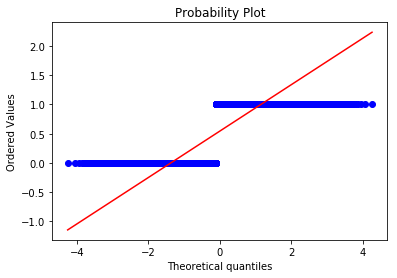

-0.18056886703997457
housing_encodedlog graph will not work
QQplot of housing_encoded (sqrt)


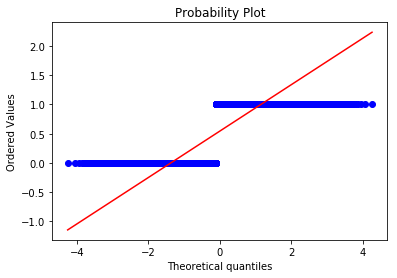

-0.18056886703997457
QQplot of housing_encoded (cubert)


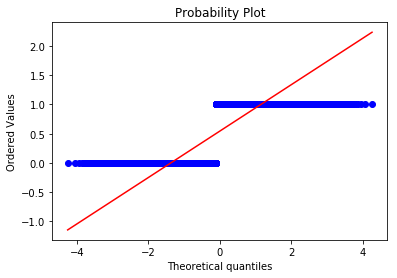

-0.18056886703997457
QQplot of loan_encoded


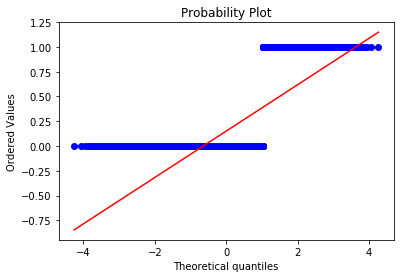

1.9504712631903636
loan_encodedlog graph will not work
QQplot of loan_encoded (sqrt)


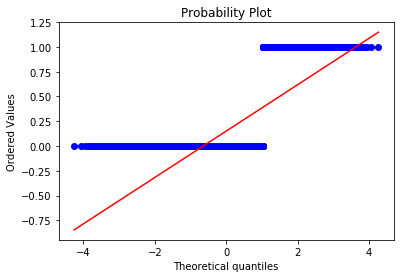

1.9504712631903636
QQplot of loan_encoded (cubert)


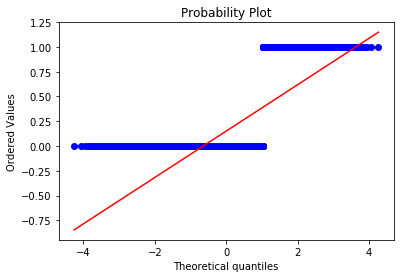

1.9504712631903636
QQplot of contact_encoded


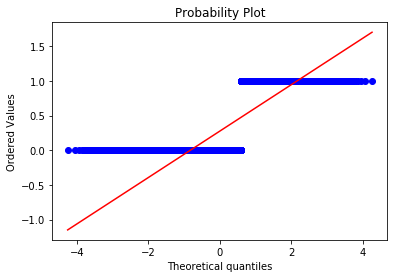

1.000972355553644
contact_encodedlog graph will not work
QQplot of contact_encoded (sqrt)


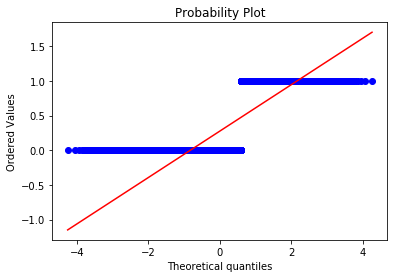

1.000972355553644
QQplot of contact_encoded (cubert)


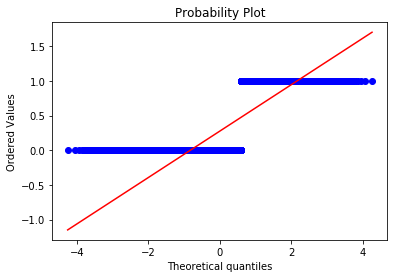

1.000972355553644
QQplot of month_encoded


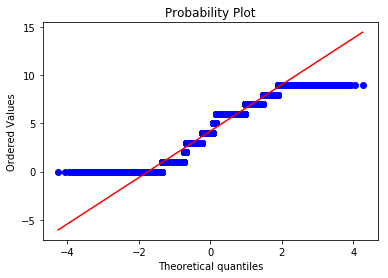

-0.16674756347642256
month_encodedlog graph will not work
QQplot of month_encoded (sqrt)


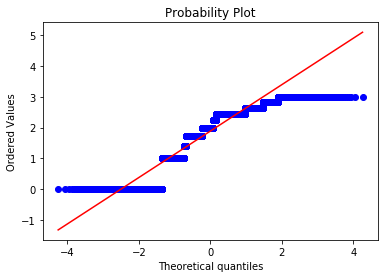

-0.9875177087741251
QQplot of month_encoded (cubert)


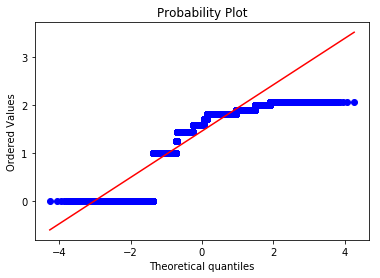

-1.559352586729856
QQplot of dayofweek_encoded


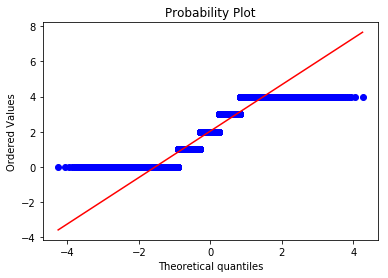

-0.028864332248686085
dayofweek_encodedlog graph will not work
QQplot of dayofweek_encoded (sqrt)


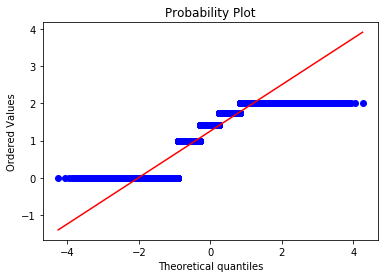

-0.8153949406132363
QQplot of dayofweek_encoded (cubert)


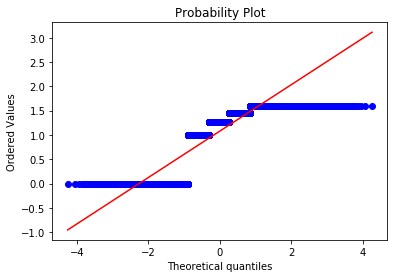

-1.1726082577822114
QQplot of poutcome_encoded


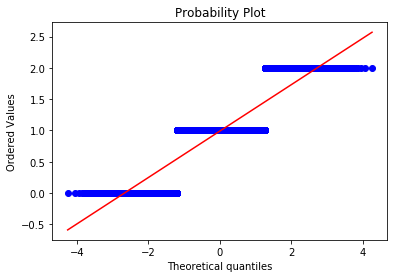

-0.03535001622374884
poutcome_encodedlog graph will not work
QQplot of poutcome_encoded (sqrt)


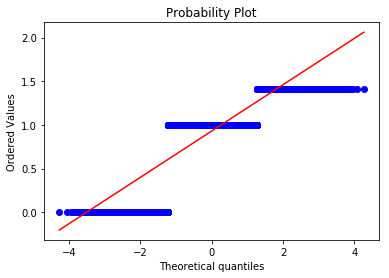

-1.7703430872341304
QQplot of poutcome_encoded (cubert)


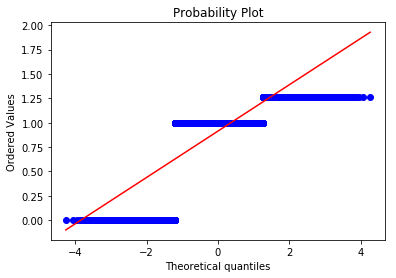

-2.160733369465757


In [17]:
import numpy as np 
import pylab 
import scipy.stats as stats
import math 

features = []
for col in X.columns:     #SOURCE - https://www.geeksforgeeks.org/how-to-get-column-names-in-pandas-dataframe/
    features.append(col)  #list of features to use in our tree from the dataset
    stats.probplot(X[col], dist="norm", plot=pylab)
    print("QQplot of " + col)
    pylab.show()
    print(X[col].skew(axis = 0, skipna= True))
    try:
        logX = X[col].apply(lambda x: math.log(x))
        stats.probplot(logX, dist="norm", plot=pylab)
        print("QQplot of " + col + " (log)")
        pylab.show()
        print(logX.skew(axis = 0, skipna = True))
    except:
        print(col + 'log graph will not work')
    try: 
        sqrtX = X[col].apply(lambda x: math.sqrt(x))
        stats.probplot(sqrtX, dist="norm", plot=pylab)
        print("QQplot of " + col + " (sqrt)")
        pylab.show()
        print(sqrtX.skew(axis = 0, skipna = True))
    except:
        print(col + 'sqrt graph will not work')
    
    try:
        cubert = X[col].apply(lambda x: math.pow(x, 1/3))
        stats.probplot(cubert, dist="norm", plot=pylab)
        print("QQplot of " + col + " (cubert)")
        pylab.show()
        print(cubert.skew(axis = 0, skipna = True))
    except:
        print(col + 'cubert graph will not work')

QQplot of pdays


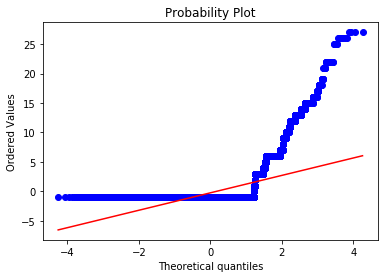

4.033659070849569
QQplot of pdays (log)


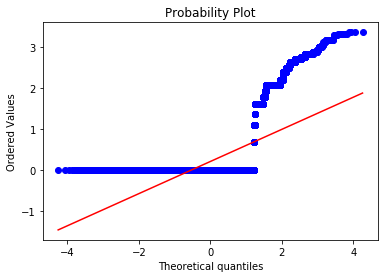

2.722804347430462
QQplot of pdays (sqrt)


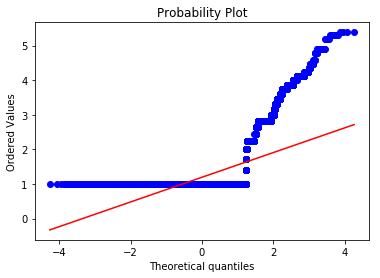

3.1271512672503468
QQplot of pdays (cubert)


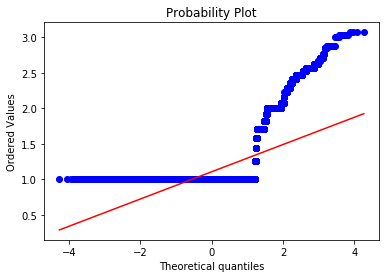

2.950797677351143
QQplot of previous


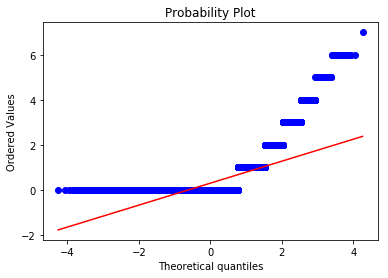

2.862043167736751
QQplot of previous (log)


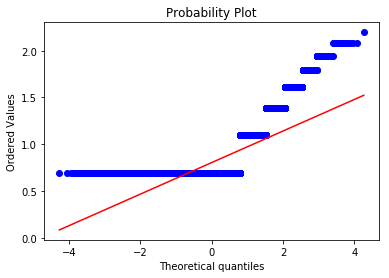

2.076648704299767
QQplot of previous (sqrt)


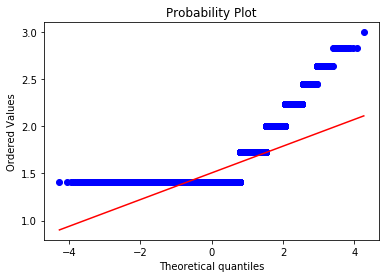

2.3975740834016563
QQplot of previous (cubert)


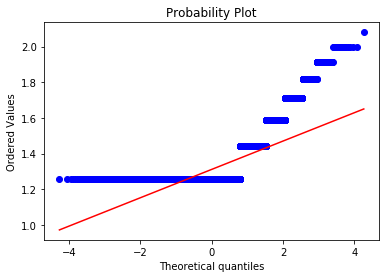

2.277052830776488
QQplot of emp.var.rate


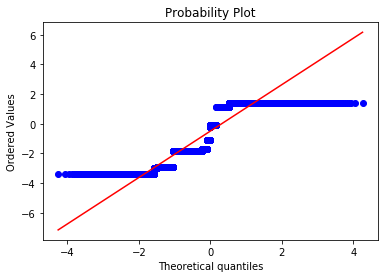

-0.1528190433781906
emp.var.ratelog graph will not work
emp.var.ratesqrt graph will not work
emp.var.ratecubert graph will not work
QQplot of cons.conf.idx


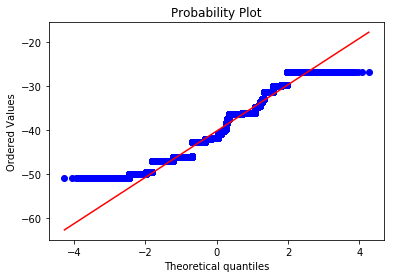

0.3488951118146305
cons.conf.idxlog graph will not work
cons.conf.idxsqrt graph will not work
cons.conf.idxcubert graph will not work
QQplot of job_encoded


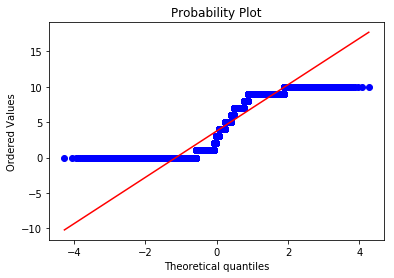

0.39763809027860214
QQplot of job_encoded (log)


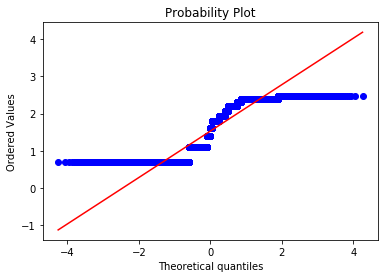

0.025025970129248596
QQplot of job_encoded (sqrt)


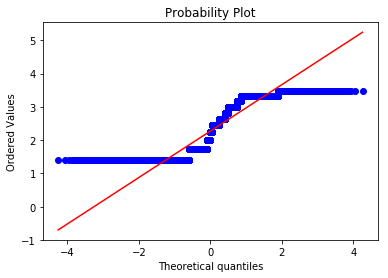

0.2134463853787997
QQplot of job_encoded (cubert)


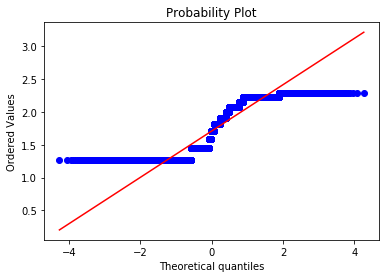

0.15079546000802696
QQplot of marital_encoded


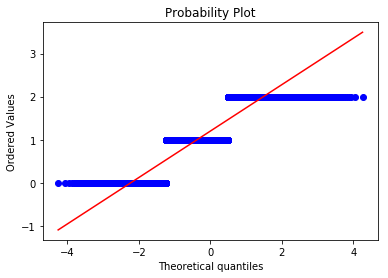

-0.1488878044510951
QQplot of marital_encoded (log)


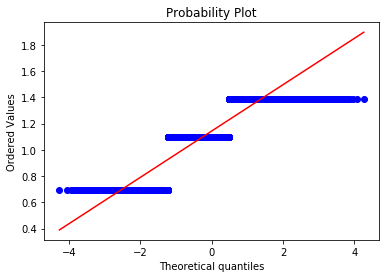

-0.6578195460276522
QQplot of marital_encoded (sqrt)


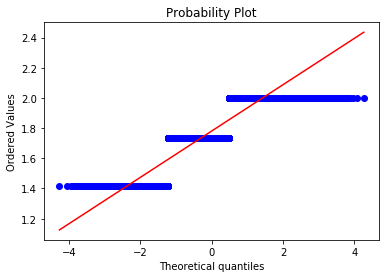

-0.3914889344699223
QQplot of marital_encoded (cubert)


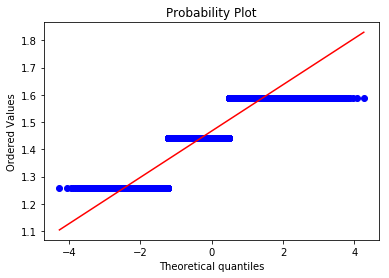

-0.47815841458844777
QQplot of education_encoded


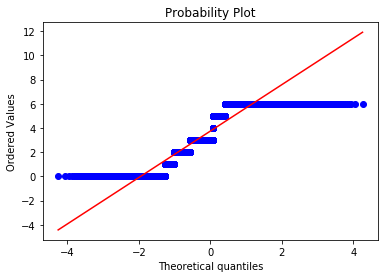

-0.34507456807422504
QQplot of education_encoded (log)


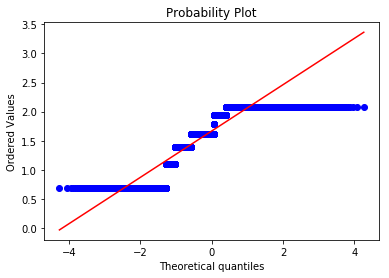

-0.9299176174781886
QQplot of education_encoded (sqrt)


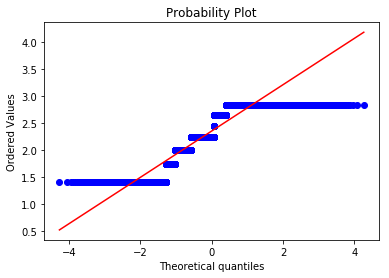

-0.6085065984930068
QQplot of education_encoded (cubert)


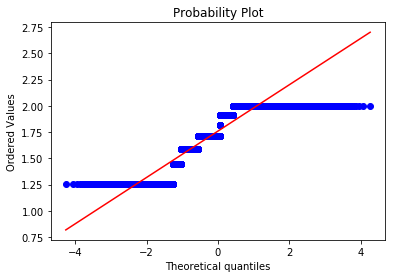

-0.710073925668459
QQplot of housing_encoded


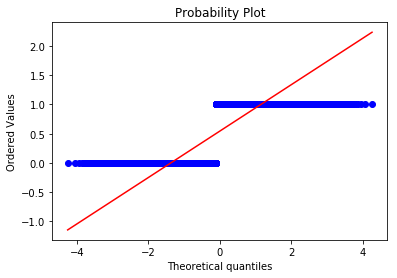

-0.18056886703997457
QQplot of housing_encoded (log)


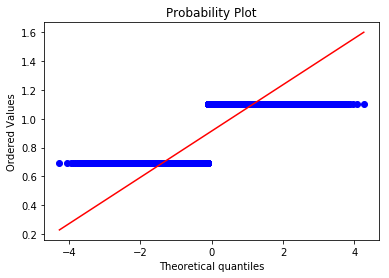

-0.18056886703997385
QQplot of housing_encoded (sqrt)


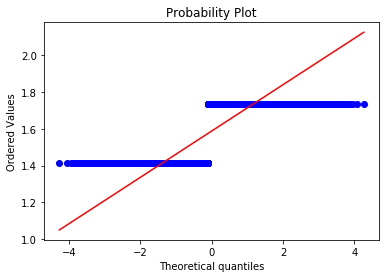

-0.18056886703998187
QQplot of housing_encoded (cubert)


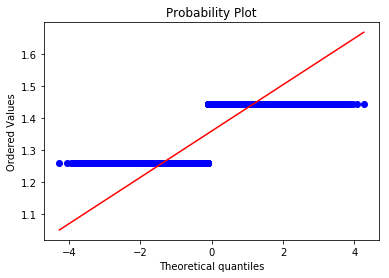

-0.1805688670399746
QQplot of loan_encoded


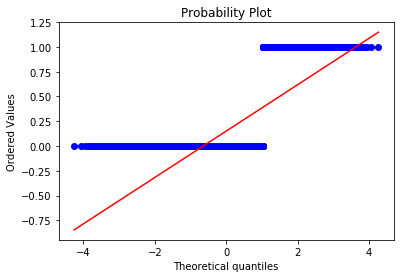

1.9504712631903636
QQplot of loan_encoded (log)


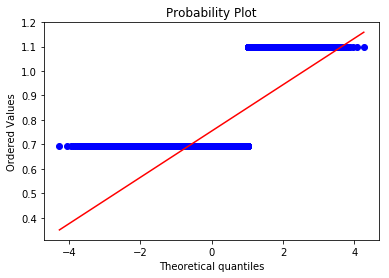

1.9504712631903651
QQplot of loan_encoded (sqrt)


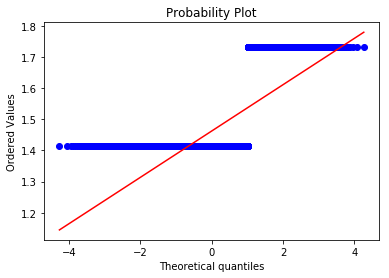

1.9504712631903551
QQplot of loan_encoded (cubert)


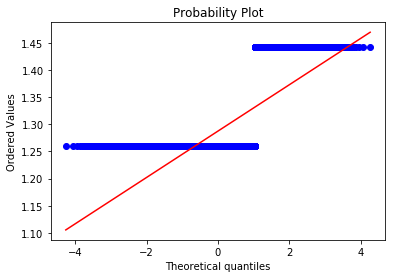

1.9504712631903582
QQplot of contact_encoded


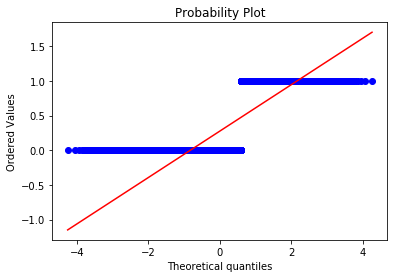

1.000972355553644
QQplot of contact_encoded (log)


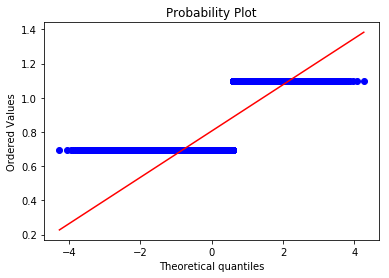

1.000972355553646
QQplot of contact_encoded (sqrt)


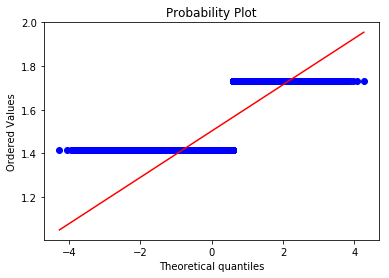

1.0009723555536354
QQplot of contact_encoded (cubert)


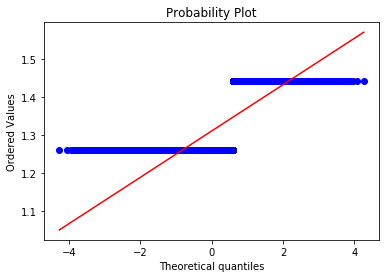

1.0009723555536452
QQplot of month_encoded


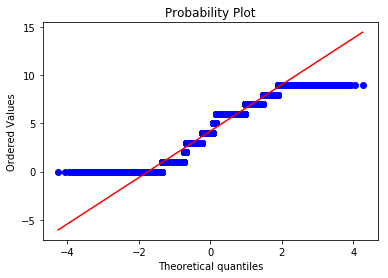

-0.16674756347642256
QQplot of month_encoded (log)


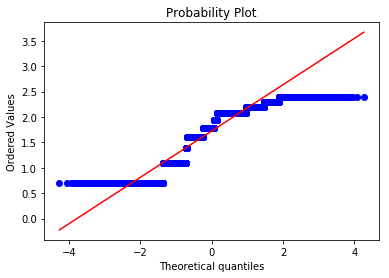

-0.7793713791874137
QQplot of month_encoded (sqrt)


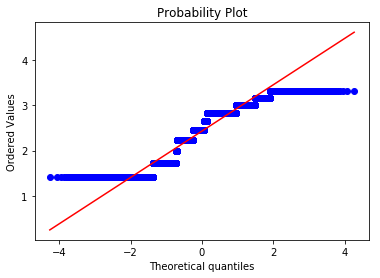

-0.46955849316362713
QQplot of month_encoded (cubert)


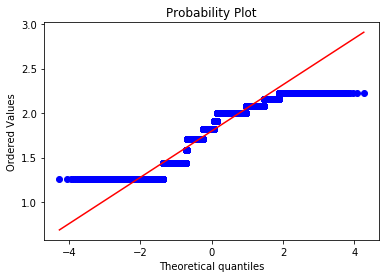

-0.5721393840632223
QQplot of dayofweek_encoded


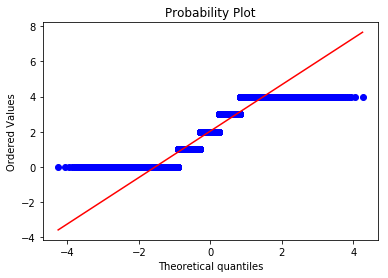

-0.028864332248686085
QQplot of dayofweek_encoded (log)


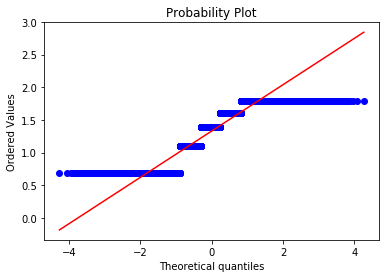

-0.45475135976186587
QQplot of dayofweek_encoded (sqrt)


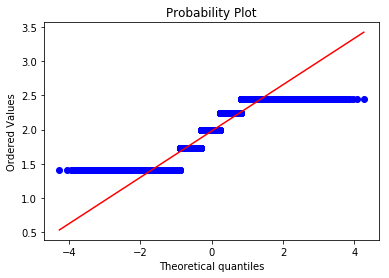

-0.23867190029865268
QQplot of dayofweek_encoded (cubert)


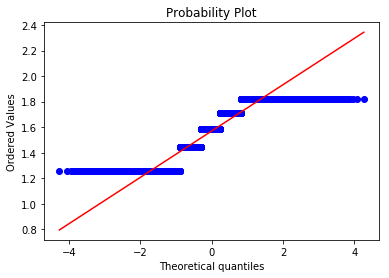

-0.3104676717278412
QQplot of poutcome_encoded


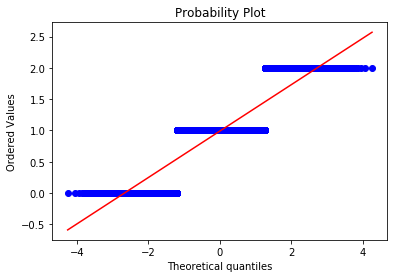

-0.03535001622374884
QQplot of poutcome_encoded (log)


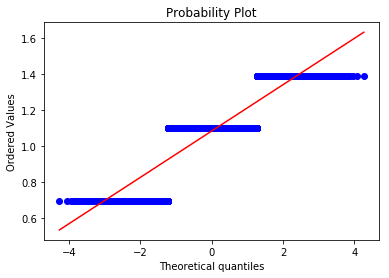

-0.8594231954264914
QQplot of poutcome_encoded (sqrt)


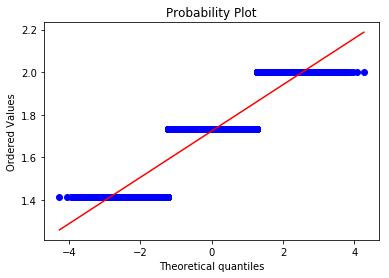

-0.46022594896535307
QQplot of poutcome_encoded (cubert)


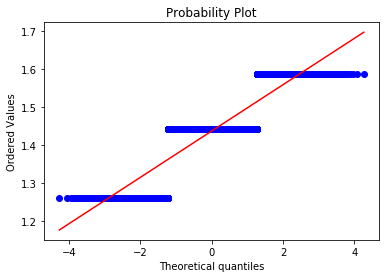

-0.5971952900356685


In [8]:
adjusted = ['pdays', 'previous', 'emp.var.rate', 'cons.conf.idx', 'job_encoded', 'marital_encoded','education_encoded', 'housing_encoded', 'loan_encoded', 'contact_encoded','month_encoded', 'dayofweek_encoded','poutcome_encoded']


for col in adjusted:     #SOURCE - https://www.geeksforgeeks.org/how-to-get-column-names-in-pandas-dataframe/
    features.append(col)  #list of features to use in our tree from the dataset
    stats.probplot(X[col], dist="norm", plot=pylab)
    print("QQplot of " + col)
    pylab.show()
    print(X[col].skew(axis = 0, skipna= True))
    try:
        logX = X[col].apply(lambda x: math.log(x+2))
        stats.probplot(logX, dist="norm", plot=pylab)
        print("QQplot of " + col + " (log)")
        pylab.show()
        print(logX.skew(axis = 0, skipna = True))
    except:
        print(col + 'log graph will not work')
    try: 
        sqrtX = X[col].apply(lambda x: math.sqrt(x+2))
        stats.probplot(sqrtX, dist="norm", plot=pylab)
        print("QQplot of " + col + " (sqrt)")
        pylab.show()
        print(sqrtX.skew(axis = 0, skipna = True))
    except:
        print(col + 'sqrt graph will not work')
    
    try:
        cubert = X[col].apply(lambda x: math.pow((x+2), 1/3))
        stats.probplot(cubert, dist="norm", plot=pylab)
        print("QQplot of " + col + " (cubert)")
        pylab.show()
        print(cubert.skew(axis = 0, skipna = True))
    except:
        print(col + 'cubert graph will not work')
    

##### Decision for Data Transformation:
Take log: <br>
age: log(x) <br>
campaign: log(x) <br>
pdays: log(x+2) <br>
previous: log(x+2) <br>
job_encoded: log(x+2) <br>
housing_encoded: log(x+2) <br>
<br>

Take square root: <br>
loan_encoded: sqrt(x+2) <br>
contact_encoded: sqrt(x+2) <br>
cons.conf.idx: sqrt(x+1-min(X)) <br>
<br>

Keep the same:
emp.var.rate <br>
cons.price.idx <br>
euribor3m <br>
nr.employed <br>
marital_encoded <br>
education_encoded <br>
month_encoded <br>
dayofweek_encoded <br>
poutcome_encoded <br>





# Model Building and Evaluation

In [3]:
np.random.seed(42)

In [4]:
X = pd.read_csv("/Users/baixiao/Desktop/X_balance.csv")
y = pd.read_csv("/Users/baixiao/Desktop/y_balance.csv")  

# Model Type I: Classification Tree

In [ ]:
def warn(*args, **kwargs):
    """disable all warings"""
    pass


# overwrite system warning function
warnings.warn = warn

# print control

## Basic Decision Tree Model

In [5]:
######################################### Imports #########################################
from sklearn.tree import DecisionTreeClassifier
from IPython.display import Image  
from sklearn import tree
import pydotplus

################################# Visualization of Decision Tree ##########################
#Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

#Build Entropy Tree
tree_basic_clf = DecisionTreeClassifier(random_state=42) # Be aware of default parameters
tree_basic_clf.fit(X_train, y_train) #apply model to the training data

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

###  Performance Metrics of Model

Performance Metrics

In [6]:
############################################# Evaluate the Model #############################################
# The sklearn.metrics module includes score functions, performance metrics and pairwise metrics 
# and distance computations.
# https://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics

from sklearn.metrics import accuracy_score, cohen_kappa_score, f1_score, classification_report

# Estimate the predicted values by applying the kNN algorithm
y_pred = tree_basic_clf.predict(X_test)
y_pred_insample = tree_basic_clf.predict(X_train)

#insample will always be higher than outofsample because model has seen the insample data before
# Accuracy
print('Accuracy (out-of-sample): %.2f' % accuracy_score(y_test, y_pred))
print('Accuracy (in-sample): %.2f' % accuracy_score(y_train, y_pred_insample))

# F1 score
print('F1 score (out-of-sample): ', f1_score(y_test, y_pred, average='macro'))
print('F1 score (in-sample)    : ', f1_score(y_train, y_pred_insample, average='macro'))

# Kappa score
print('Kappa score (out-of-sample): ', cohen_kappa_score(y_test, y_pred))
print('Kappa score (in-sample)    : ', cohen_kappa_score(y_train, y_pred_insample))
# Build a text report showing the main classification metrics (out-of-sample performance)
print(classification_report(y_test, y_pred))

Accuracy (out-of-sample): 0.94
Accuracy (in-sample): 1.00
F1 score (out-of-sample):  0.9406749143304347
F1 score (in-sample)    :  0.9956845209777654
Kappa score (out-of-sample):  0.8817090411866169
Kappa score (in-sample)    :  0.9913691884080084
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      8488
           1       0.90      1.00      0.94      8506

   micro avg       0.94      0.94      0.94     16994
   macro avg       0.95      0.94      0.94     16994
weighted avg       0.95      0.94      0.94     16994



Fitting Curve

/anaconda3/envs/IntroToBA_Project/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/anaconda3/envs/IntroToBA_Project/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/anaconda3/envs/IntroToBA_Project/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/anaconda3/envs/IntroToBA_Project/lib/python3.7/s

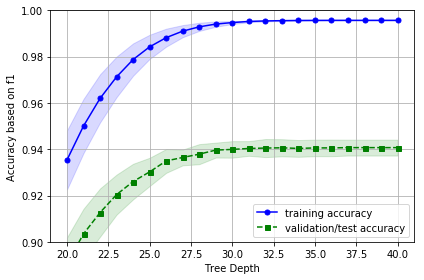

In [7]:
############################### Import Libraries & Modules #################################

# Fitting curve (aka validation curve)
# Determine training and test scores for varying parameter values.
from sklearn.model_selection import validation_curve
# Split validation
from sklearn.model_selection import train_test_split

np.random.seed(42) #the seed used by the random number generator for np

############################# Parameters - Varying Complexity #############################

# Specify possible parameter values for max_depth
param_range = [20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]

# Compute scores for an estimator with different values of a specified parameter. 
# This is similar to grid search with one parameter. 
# However, this will also compute training scores and is merely a utility for plotting the results.

########################## Estimate Scores - Varying Complexity ##########################

# Determine training and test scores for varying parameter values.
train_scores, test_scores = validation_curve( 
                estimator=DecisionTreeClassifier(criterion='gini', random_state=42), #Build Decision Trees
                X=X_train, 
                y=y_train, 
                param_name="max_depth", # parameter max depth
                param_range= param_range,
                cv=10,     #10-fold cross-validation
                scoring="f1", 
                n_jobs=4) # Number of CPU cores used when parallelizing over classes if multi_class=’ovr’”. This parameter is ignored when the ``solver``is set to ‘liblinear’ regardless of whether ‘multi_class’ is specified or not. If given a value of -1, all cores are used.


# Cross validation statistics for training and testing data (mean and standard deviation)
train_mean = np.mean(train_scores, axis=1) # Compute the arithmetic mean along the specified axis.
train_std = np.std(train_scores, axis=1)   # Compute the standard deviation along the specified axis.
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

############################## Visualization - Fitting Graph ##############################

# Plot train accuracy means of cross-validation for all the parameters max_depth in param_range
plt.plot(param_range, train_mean, 
         color='blue', marker='o', 
         markersize=5, label='training accuracy')

# Fill the area around the line to indicate the size of standard deviations of performance for the training data
plt.fill_between(param_range, train_mean + train_std,
                 train_mean - train_std, alpha=0.15,
                 color='blue')

# Plot test accuracy means of cross-validation for all the parameters max_depth in param_range
plt.plot(param_range, test_mean, 
         color='green', linestyle='--', 
         marker='s', markersize=5, 
         label='validation/test accuracy')

# Fill the area around the line to indicate the size of standard deviations of performance for the test data
plt.fill_between(param_range, 
                 test_mean + test_std,
                 test_mean - test_std, 
                 alpha=0.15, color='green')

# Grid and Axes Titles
plt.grid()
plt.legend(loc='lower right')
plt.xlabel('Tree Depth')
plt.ylabel('Accuracy based on f1')
plt.ylim([0.90, 1.0]) # y limits in the plot
plt.tight_layout()
# plt.savefig('Fitting_graph_LR.png', dpi=300)
plt.show()           # Display the figure

/anaconda3/envs/IntroToBA_Project/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/anaconda3/envs/IntroToBA_Project/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/anaconda3/envs/IntroToBA_Project/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/anaconda3/envs/IntroToBA_Project/lib/python3.7/s

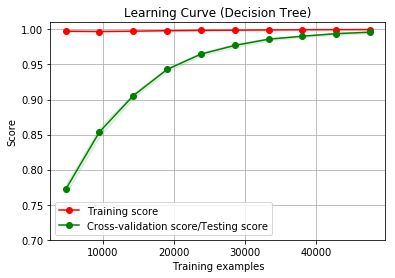

In [8]:
############################## Function for Learning Curves ##############################

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, num = 10)):
   
    plt.figure()                    #display figure
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples") #y label title
    plt.ylabel("Score")             #x label title
    
    # Class learning_curve determines cross-validated training and test scores for different training set sizes
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring = 'recall')
    
    # Cross validation statistics for training and testing data (mean and standard deviation)
    train_scores_mean = np.mean(train_scores, axis=1) # Compute the arithmetic mean along the specified axis.
    train_scores_std = np.std(train_scores, axis=1)   # Compute the standard deviation along the specified axis.
    test_scores_mean = np.mean(test_scores, axis=1)   # Compute the arithmetic mean along the specified axis.
    test_scores_std = np.std(test_scores, axis=1)     # Compute the standard deviation along the specified axis.

    plt.grid() # Configure the grid lines

    # Fill the area around the line to indicate the size of standard deviations for the training data
    # and the test data
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r") # train data performance indicated with red
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g") # test data performance indicated with green
    
    # Cross-validation means indicated by dots
    # Train data performance indicated with red
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    # Test data performance indicated with green
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score/Testing score")

    plt.legend(loc="best") # Show legend of the plot at the best location possible
    return plt             # Function that returns the plot as an output
########################### Visualization of Learning Curves ###########################

# Determines cross-validated training and test scores for different training set sizes
from sklearn.model_selection import learning_curve 
# Random permutation cross-validator
from sklearn.model_selection import ShuffleSplit
# Logistic regression classifier class
from sklearn.linear_model import LogisticRegression
# kNN classifier class
from sklearn import neighbors
# Each pyplot function makes some change to a figure: e.g., creates a figure, creates a plotting area in a figure, 
# plots some lines in a plotting area, decorates the plot with labels, etc
import matplotlib.pyplot as plt


title = "Learning Curve (Decision Tree)"

# Class ShuffleSplit is a random permutation cross-validator
# Parameter n_splits = Number of re-shuffling & splitting iterations
# Parameter test_size = represents the proportion of the dataset to include in the test split (float between 0.0 and 1.0) 
# Parameter random_state = the seed used by the random number generator
cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=42)
estimator = DecisionTreeClassifier(criterion = 'gini',random_state = 42) # Make it the same as our optimal parameters, Build multiple LRs as we increase the size of the traning data
# Plots the learning curve based on the previously defined function for the logistic regression estimator
plot_learning_curve(estimator, title, X, y, (0.7, 1.01), cv=cv, n_jobs=4)

plt.show() # Display the figure



## Decision Tree Optimization

In [9]:
################################# Nested Cross-Validation #################################

##################################### Parameter Tuning ####################################

# Exhaustive search over specified parameter values for an estimator.
# GridSearchCV implements a “fit” and a “score” method. 
# It also implements “predict”, “predict_proba”, “decision_function”, “transform” and “inverse_transform” 
# if they are implemented in the estimator used.

# The parameters of the estimator used to apply these methods are optimized by cross-validated 
# grid-search over a parameter grid.

inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)
outer_cv = KFold(n_splits=5, shuffle=True, random_state= 42)

############################## Decision Tree Parameter Tuning ##############################
# See all the parameters you can optimize here http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

# Choosing depth of the tree AND splitting criterion AND min_samples_split
gs_dt2 = GridSearchCV(estimator=DecisionTreeClassifier(random_state=42),
                  param_grid=[{'max_depth': [25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40], 'criterion':['gini','entropy'], 
                              'min_samples_split':[10, 11, 12, 13 , 14, 15, 16, 17, 18, 19, 20]}],
                  scoring='f1',
                  cv=inner_cv
                  #n_jobs=4
                  )

gs_dt2 = gs_dt2.fit(X,y)
print("Parameter Tuning Decision Tree")
print("Non-nested CV Accuracy: ", gs_dt2.best_score_)
print("Optimal Parameter: ", gs_dt2.best_params_)
print("Optimal Estimator: ", gs_dt2.best_estimator_)
nested_score_gs_dt2 = cross_val_score(gs_dt2, X=X, y=y, cv=outer_cv)
print("Nested CV Accuracy: ",nested_score_gs_dt2.mean(), " +/- ", nested_score_gs_dt2.std())

Parameter Tuning Decision Tree
Non-nested CV Accuracy:  0.9228161613986926
Optimal Parameter:  {'criterion': 'entropy', 'max_depth': 38, 'min_samples_split': 10}
Optimal Estimator:  DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=38,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')


KeyboardInterrupt: 

Parameter Tuning Decision Tree<br>
Non-nested CV Accuracy:  0.9228161613986926<br>
Optimal Parameter:  {'criterion': 'entropy', 'max_depth': 38, 'min_samples_split': 10}<br>
Optimal Estimator:  DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=38,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')<br>
Nested CV Accuracy:  0.9227531952564112  +/-  0.0023144015823847214<br>

### Base Optimized Model

In [15]:
######################################### Imports #########################################
from sklearn.tree import DecisionTreeClassifier
from IPython.display import Image  
from sklearn import tree
import pydotplus

################################# Visualization of Decision Tree ##########################
#Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

#Build Entropy Tree
tree_basic_opt_clf = DecisionTreeClassifier(criterion = "entropy", max_depth=38, min_samples_split = 10, random_state=42) # Be aware of default parameters
tree_basic_opt_clf.fit(X_train, y_train) #apply model to the training data

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=38,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

### Metrics

In [16]:
############################################# Evaluate the Model #############################################
# The sklearn.metrics module includes score functions, performance metrics and pairwise metrics 
# and distance computations.
# https://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics

from sklearn.metrics import accuracy_score, cohen_kappa_score, f1_score, classification_report

# Estimate the predicted values by applying the kNN algorithm
y_pred = tree_basic_opt_clf.predict(X_test)
y_pred_insample = tree_basic_opt_clf.predict(X_train)

#insample will always be higher than outofsample because model has seen the insample data before
# Accuracy
print('Accuracy (out-of-sample): %.2f' % accuracy_score(y_test, y_pred))
print('Accuracy (in-sample): %.2f' % accuracy_score(y_train, y_pred_insample))

# F1 score
print('F1 score (out-of-sample): ', f1_score(y_test, y_pred, average='macro'))
print('F1 score (in-sample)    : ', f1_score(y_train, y_pred_insample, average='macro'))

# Kappa score
print('Kappa score (out-of-sample): ', cohen_kappa_score(y_test, y_pred))
print('Kappa score (in-sample)    : ', cohen_kappa_score(y_train, y_pred_insample))
# Build a text report showing the main classification metrics (out-of-sample performance)
print(classification_report(y_test, y_pred))

Accuracy (out-of-sample): 0.91
Accuracy (in-sample): 0.97
F1 score (out-of-sample):  0.9136389320187155
F1 score (in-sample)    :  0.9706304250221646
Kappa score (out-of-sample):  0.8276859597891131
Kappa score (in-sample)    :  0.9412716414989077
              precision    recall  f1-score   support

           0       0.96      0.87      0.91      8488
           1       0.88      0.96      0.92      8506

   micro avg       0.91      0.91      0.91     16994
   macro avg       0.92      0.91      0.91     16994
weighted avg       0.92      0.91      0.91     16994



###  Fitting Curve and Learning Curve

In [0]:
############################### Import Libraries & Modules #################################

# Fitting curve (aka validation curve)
# Determine training and test scores for varying parameter values.
from sklearn.model_selection import validation_curve
# Split validation
from sklearn.model_selection import train_test_split

np.random.seed(42) #the seed used by the random number generator for np

############################# Parameters - Varying Complexity #############################

# Specify possible parameter values for max_depth
param_range = [20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]

# Compute scores for an estimator with different values of a specified parameter. 
# This is similar to grid search with one parameter. 
# However, this will also compute training scores and is merely a utility for plotting the results.

########################## Estimate Scores - Varying Complexity ##########################

# Determine training and test scores for varying parameter values.
train_scores, test_scores = validation_curve( 
                estimator=DecisionTreeClassifier(criterion='entropy', max_depth = 38, min_samples_split= 10, random_state=42), #Build Decision Trees
                X=X_train, 
                y=y_train, 
                param_name="max_depth", # parameter max depth
                param_range= param_range,
                cv=10,     #10-fold cross-validation
                scoring="f1", 
                n_jobs=4) # Number of CPU cores used when parallelizing over classes if multi_class=’ovr’”. This parameter is ignored when the ``solver``is set to ‘liblinear’ regardless of whether ‘multi_class’ is specified or not. If given a value of -1, all cores are used.


# Cross validation statistics for training and testing data (mean and standard deviation)
train_mean = np.mean(train_scores, axis=1) # Compute the arithmetic mean along the specified axis.
train_std = np.std(train_scores, axis=1)   # Compute the standard deviation along the specified axis.
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

############################## Visualization - Fitting Graph ##############################

# Plot train accuracy means of cross-validation for all the parameters max_depth in param_range
plt.plot(param_range, train_mean, 
         color='blue', marker='o', 
         markersize=5, label='training accuracy')

# Fill the area around the line to indicate the size of standard deviations of performance for the training data
plt.fill_between(param_range, train_mean + train_std,
                 train_mean - train_std, alpha=0.15,
                 color='blue')

# Plot test accuracy means of cross-validation for all the parameters max_depth in param_range
plt.plot(param_range, test_mean, 
         color='green', linestyle='--', 
         marker='s', markersize=5, 
         label='validation/test accuracy')

# Fill the area around the line to indicate the size of standard deviations of performance for the test data
plt.fill_between(param_range, 
                 test_mean + test_std,
                 test_mean - test_std, 
                 alpha=0.15, color='green')

# Grid and Axes Titles
plt.grid()
plt.legend(loc='lower right')
plt.xlabel('Tree Depth')
plt.ylabel('Accuracy based on f1')
plt.ylim([0.85, 1.0]) # y limits in the plot
plt.tight_layout()
# plt.savefig('Fitting_graph_LR.png', dpi=300)
plt.show()           # Display the figure



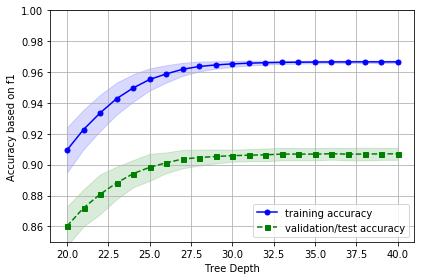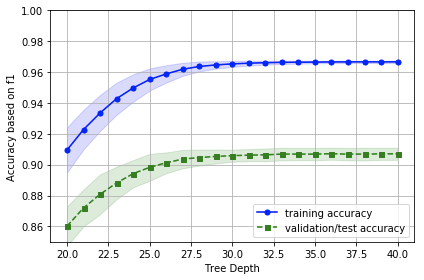

In [0]:
############################## Function for Learning Curves ##############################

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, num = 10)):
    
    plt.figure()                    #display figure
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples") #y label title
    plt.ylabel("Score")             #x label title
    
    # Class learning_curve determines cross-validated training and test scores for different training set sizes
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring = 'recall')
    
    # Cross validation statistics for training and testing data (mean and standard deviation)
    train_scores_mean = np.mean(train_scores, axis=1) # Compute the arithmetic mean along the specified axis.
    train_scores_std = np.std(train_scores, axis=1)   # Compute the standard deviation along the specified axis.
    test_scores_mean = np.mean(test_scores, axis=1)   # Compute the arithmetic mean along the specified axis.
    test_scores_std = np.std(test_scores, axis=1)     # Compute the standard deviation along the specified axis.

    plt.grid() # Configure the grid lines

    # Fill the area around the line to indicate the size of standard deviations for the training data
    # and the test data
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r") # train data performance indicated with red
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g") # test data performance indicated with green
    
    # Cross-validation means indicated by dots
    # Train data performance indicated with red
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    # Test data performance indicated with green
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score/Testing score")

    plt.legend(loc="best") # Show legend of the plot at the best location possible
    return plt             # Function that returns the plot as an output
########################### Visualization of Learning Curves ###########################

# Determines cross-validated training and test scores for different training set sizes
from sklearn.model_selection import learning_curve 
# Random permutation cross-validator
from sklearn.model_selection import ShuffleSplit
# Logistic regression classifier class
from sklearn.linear_model import LogisticRegression
# kNN classifier class
from sklearn import neighbors
# Each pyplot function makes some change to a figure: e.g., creates a figure, creates a plotting area in a figure, 
# plots some lines in a plotting area, decorates the plot with labels, etc
import matplotlib.pyplot as plt


title = "Learning Curve (Decision Tree)"

# Class ShuffleSplit is a random permutation cross-validator
# Parameter n_splits = Number of re-shuffling & splitting iterations
# Parameter test_size = represents the proportion of the dataset to include in the test split (float between 0.0 and 1.0) 
# Parameter random_state = the seed used by the random number generator
cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=42)
estimator = DecisionTreeClassifier(criterion='entropy', max_depth = 38, min_samples_split= 10, random_state = 42) # Make it the same as our optimal parameters, Build multiple LRs as we increase the size of the traning data
# Plots the learning curve based on the previously defined function for the logistic regression estimator
plot_learning_curve(estimator, title, X, y, (0.7, 1.01), cv=cv, n_jobs=4)

plt.show() # Display the figure


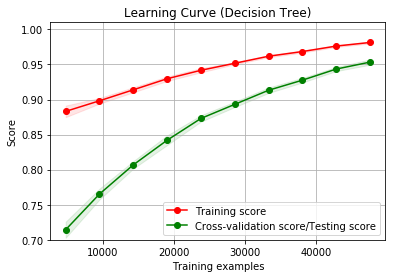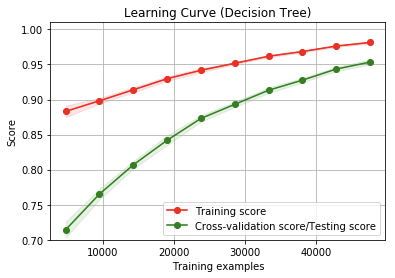

### Transformed Optimized Model

### Optimize parameters

In [0]:
######################################### Imports #########################################
from sklearn.tree import DecisionTreeClassifier
from IPython.display import Image  
from sklearn import tree
import pydotplus

################################# ReDeclare the X and Y ##########################
X = pd.read_csv("/Users/baixiao/Desktop/X_transformed.csv")  
y = pd.read_csv("/Users/baixiao/Desktop/y_balance.csv")

################################# Nested Cross-Validation #################################

##################################### Parameter Tuning ####################################

# Exhaustive search over specified parameter values for an estimator.
# GridSearchCV implements a “fit” and a “score” method. 
# It also implements “predict”, “predict_proba”, “decision_function”, “transform” and “inverse_transform” 
# if they are implemented in the estimator used.

# The parameters of the estimator used to apply these methods are optimized by cross-validated 
# grid-search over a parameter grid.

inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)
<b
############################## Decision Tree Parameter Tuning ##############################
# See all the parameters you can optimize here http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

# Choosing depth of the tree AND splitting criterion AND min_samples_split
gs_dt2 = GridSearchCV(estimator=DecisionTreeClassifier(random_state=42),
                  param_grid=[{'max_depth': [25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40], 'criterion':['gini','entropy'], 
                              'min_samples_split':[10, 11, 12, 13 , 14, 15, 16, 17, 18, 19, 20]}],
                  scoring='f1',
                  cv=inner_cv,
                  n_jobs=4)

gs_dt2 = gs_dt2.fit(X,y)
print("Parameter Tuning Decision Tree")
print("Non-nested CV Accuracy: ", gs_dt2.best_score_)
print("Optimal Parameter: ", gs_dt2.best_params_)
print("Optimal Estimator: ", gs_dt2.best_estimator_)
nested_score_gs_dt2 = cross_val_score(gs_dt2, X=X, y=y, cv=outer_cv)
print("Nested CV Accuracy: ",nested_score_gs_dt2.mean(), " +/- ", nested_score_gs_dt2.std())

Parameter Tuning Decision Tree<br>
Non-nested CV Accuracy:  0.9229513440866125<br>
Optimal Parameter:  {'criterion': 'entropy', 'max_depth': 36, 'min_samples_split': 10}<br>
Optimal Estimator:  DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=36,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')<br>
Nested CV Accuracy:  0.922594831084852  +/-  0.0022775259142253606<br>

### Run Model

In [0]:
######################################### Imports #########################################
from sklearn.tree import DecisionTreeClassifier
from IPython.display import Image  
from sklearn import tree
import pydotplus

################################# Visualization of Decision Tree ##########################
#Split the data into training and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

#Build Entropy Tree
tree_tran_opt_clf = DecisionTreeClassifier(criterion = "entropy", max_depth=36, min_samples_split = 10, random_state=42) # Be aware of default parameters
tree_tran_opt_clf.fit(X_train, y_train) #apply model to the training data

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=36,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

### Metrics

In [0]:
############################################# Evaluate the Model #############################################
# The sklearn.metrics module includes score functions, performance metrics and pairwise metrics 
# and distance computations.
# https://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics

from sklearn.metrics import accuracy_score, cohen_kappa_score, f1_score, classification_report

# Estimate the predicted values by applying the kNN algorithm
y_pred = tree_tran_opt_clf.predict(X_test)
y_pred_insample = tree_tran_opt_clf.predict(X_train)

#insample will always be higher than outofsample because model has seen the insample data before
# Accuracy
print('Accuracy (out-of-sample): %.2f' % accuracy_score(y_test, y_pred))
print('Accuracy (in-sample): %.2f' % accuracy_score(y_train, y_pred_insample))

# F1 score
print('F1 score (out-of-sample): ', f1_score(y_test, y_pred, average='macro'))
print('F1 score (in-sample)    : ', f1_score(y_train, y_pred_insample, average='macro'))

# Kappa score
print('Kappa score (out-of-sample): ', cohen_kappa_score(y_test, y_pred))
print('Kappa score (in-sample)    : ', cohen_kappa_score(y_train, y_pred_insample))
# Build a text report showing the main classification metrics (out-of-sample performance)
print(classification_report(y_test, y_pred))

Accuracy (out-of-sample): 0.91<br>
Accuracy (in-sample): 0.97<br>
F1 score (out-of-sample):  0.9124466486923817
F1 score (in-sample)    :  0.9704930156347895
Kappa score (out-of-sample):  0.8253314202305714
Kappa score (in-sample)    :  0.9409970306825134
              precision    recall  f1-score   support

           0       0.96      0.86      0.91      8488
           1       0.88      0.96      0.92      8506

   micro avg       0.91      0.91      0.91     16994
   macro avg       0.92      0.91      0.91     16994
weighted avg       0.92      0.91      0.91     16994

### Fitting Curve and Learning Curve

In [0]:
############################### Import Libraries & Modules #################################

# Fitting curve (aka validation curve)
# Determine training and test scores for varying parameter values.
from sklearn.model_selection import validation_curve
# Split validation
from sklearn.model_selection import train_test_split

np.random.seed(42) #the seed used by the random number generator for np

############################# Parameters - Varying Complexity #############################

# Specify possible parameter values for max_depth
param_range = [20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]

# Compute scores for an estimator with different values of a specified parameter. 
# This is similar to grid search with one parameter. 
# However, this will also compute training scores and is merely a utility for plotting the results.

########################## Estimate Scores - Varying Complexity ##########################

# Determine training and test scores for varying parameter values.
train_scores, test_scores = validation_curve( 
                estimator=DecisionTreeClassifier(criterion='entropy', max_depth = 36, min_samples_split= 10, random_state=42), #Build Decision Trees
                X=X_train, 
                y=y_train, 
                param_name="max_depth", # parameter max depth
                param_range= param_range,
                cv=10,     #10-fold cross-validation
                scoring="f1", 
                n_jobs=4) # Number of CPU cores used when parallelizing over classes if multi_class=’ovr’”. This parameter is ignored when the ``solver``is set to ‘liblinear’ regardless of whether ‘multi_class’ is specified or not. If given a value of -1, all cores are used.


# Cross validation statistics for training and testing data (mean and standard deviation)
train_mean = np.mean(train_scores, axis=1) # Compute the arithmetic mean along the specified axis.
train_std = np.std(train_scores, axis=1)   # Compute the standard deviation along the specified axis.
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

############################## Visualization - Fitting Graph ##############################

# Plot train accuracy means of cross-validation for all the parameters max_depth in param_range
plt.plot(param_range, train_mean, 
         color='blue', marker='o', 
         markersize=5, label='training accuracy')

# Fill the area around the line to indicate the size of standard deviations of performance for the training data
plt.fill_between(param_range, train_mean + train_std,
                 train_mean - train_std, alpha=0.15,
                 color='blue')

# Plot test accuracy means of cross-validation for all the parameters max_depth in param_range
plt.plot(param_range, test_mean, 
         color='green', linestyle='--', 
         marker='s', markersize=5, 
         label='validation/test accuracy')

# Fill the area around the line to indicate the size of standard deviations of performance for the test data
plt.fill_between(param_range, 
                 test_mean + test_std,
                 test_mean - test_std, 
                 alpha=0.15, color='green')

# Grid and Axes Titles
plt.grid()
plt.legend(loc='lower right')
plt.xlabel('Tree Depth')
plt.ylabel('Accuracy based on f1')
plt.ylim([0.85, 1.0]) # y limits in the plot
plt.tight_layout()
# plt.savefig('Fitting_graph_LR.png', dpi=300)
plt.show()           # Display the figure


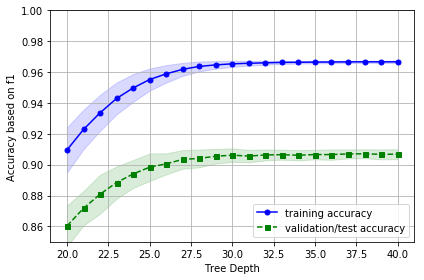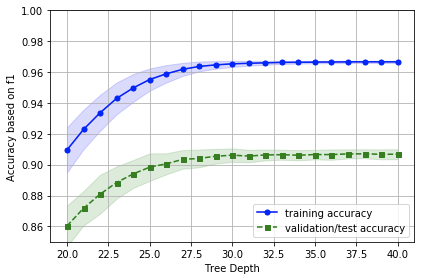

In [0]:
############################## Function for Learning Curves ##############################

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, num = 10)):
   
    plt.figure()                    #display figure
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples") #y label title
    plt.ylabel("Score")             #x label title
    
    # Class learning_curve determines cross-validated training and test scores for different training set sizes
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring = 'recall')
    
    # Cross validation statistics for training and testing data (mean and standard deviation)
    train_scores_mean = np.mean(train_scores, axis=1) # Compute the arithmetic mean along the specified axis.
    train_scores_std = np.std(train_scores, axis=1)   # Compute the standard deviation along the specified axis.
    test_scores_mean = np.mean(test_scores, axis=1)   # Compute the arithmetic mean along the specified axis.
    test_scores_std = np.std(test_scores, axis=1)     # Compute the standard deviation along the specified axis.

    plt.grid() # Configure the grid lines

    # Fill the area around the line to indicate the size of standard deviations for the training data
    # and the test data
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r") # train data performance indicated with red
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g") # test data performance indicated with green
    
    # Cross-validation means indicated by dots
    # Train data performance indicated with red
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    # Test data performance indicated with green
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score/Testing score")

    plt.legend(loc="best") # Show legend of the plot at the best location possible
    return plt             # Function that returns the plot as an output
########################### Visualization of Learning Curves ###########################

# Determines cross-validated training and test scores for different training set sizes
from sklearn.model_selection import learning_curve 
# Random permutation cross-validator
from sklearn.model_selection import ShuffleSplit
# Logistic regression classifier class
from sklearn.linear_model import LogisticRegression
# kNN classifier class
from sklearn import neighbors
# Each pyplot function makes some change to a figure: e.g., creates a figure, creates a plotting area in a figure, 
# plots some lines in a plotting area, decorates the plot with labels, etc
import matplotlib.pyplot as plt


title = "Learning Curve (Decision Tree)"

# Class ShuffleSplit is a random permutation cross-validator
# Parameter n_splits = Number of re-shuffling & splitting iterations
# Parameter test_size = represents the proportion of the dataset to include in the test split (float between 0.0 and 1.0) 
# Parameter random_state = the seed used by the random number generator
cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=42)
estimator = DecisionTreeClassifier(criterion = 'entropy',max_depth = 36, min_samples_split = 10 ,random_state = 42) # Make it the same as our optimal parameters, Build multiple LRs as we increase the size of the traning data
# Plots the learning curve based on the previously defined function for the logistic regression estimator
plot_learning_curve(estimator, title, X, y, (0.7, 1.01), cv=cv, n_jobs=4)

plt.show() # Display the figure



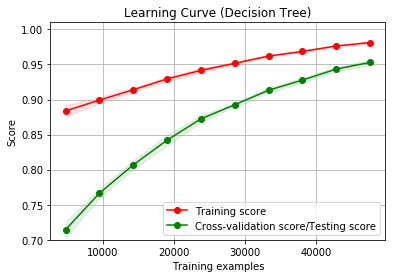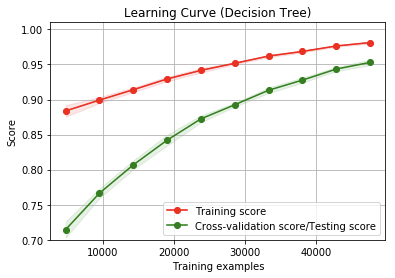

## Model Type II: Logistic Regression (with regularization)

In [17]:
import matplotlib.pylab as pl
import warnings
from sklearn.linear_model import LogisticRegression
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve
from sklearn.metrics import auc

from sklearn.model_selection import train_test_split
from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import accuracy_score, cohen_kappa_score, f1_score, classification_report

def warn(*args, **kwargs):
    """disable all warings"""
    pass


# overwrite system warning function
warnings.warn = warn
# print control

class color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'

color.SET = color.UNDERLINE + color.BOLD + color.BLUE

# plot color control

classifications = ['1', '0']

inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
np.random.seed(42)

In [ ]:
############################## Function for Learning Curves ##############################


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, num=10)):

    plt.figure()  # display figure
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")  # y label title
    plt.ylabel("Score")  # x label title

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='f1')

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")  # train data performance indicated with red
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")  # test data performance indicated with green

    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")

    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score/Testing score")

    plt.legend(loc="best")
    return plt             # Function that returns the plot as an output

### Basic Logistic Regression model

In [ ]:
X = pd.read_csv("/Users/baixiao/Desktop/X_balance.csv')
y = pd.read_csv("/Users/baixiao/Desktop/y_balance.csv")
                
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [ ]:
estimator = LogisticRegression(random_state=42)
estimator.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
y_pred = estimator.predict(X_test)
y_pred_insample = estimator.predict(X_train)

print('Accuracy (out-of-sample): %.2f' % accuracy_score(y_test, y_pred))
print('Accuracy (in-sample): %.2f' % accuracy_score(y_train, y_pred_insample))

# F1 score
print('F1 score (out-of-sample): ', f1_score(y_test, y_pred, average='macro'))
print('F1 score (in-sample)    : ',
      f1_score(y_train, y_pred_insample, average='macro'))

# Kappa score
print('Kappa score (out-of-sample): ', cohen_kappa_score(y_test, y_pred))
print('Kappa score (in-sample)    : ',
      cohen_kappa_score(y_train, y_pred_insample))

# Build a text report showing the main classification metrics (out-of-sample performance)
print(classification_report(y_test, y_pred, target_names=classifications))

Accuracy (out-of-sample): 0.73
Accuracy (in-sample): 0.73
F1 score (out-of-sample):  0.7273684840164378
F1 score (in-sample)    :  0.7292898611050469
Kappa score (out-of-sample):  0.4595633943926605
Kappa score (in-sample)    :  0.4632053834041264
              precision    recall  f1-score   support

           1       0.69      0.82      0.75      8488
           0       0.78      0.64      0.70      8506

    accuracy                           0.73     16994
   macro avg       0.74      0.73      0.73     16994
weighted avg       0.74      0.73      0.73     16994


### Learning curve

In [ ]:
########################### Visualization of Learning Curves ###########################
title = "Learning Curve of Logistic Regression - f-1 Score"

cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=42)

plot_learning_curve(estimator, title, X, y, cv=cv, n_jobs=8)

plt.show()

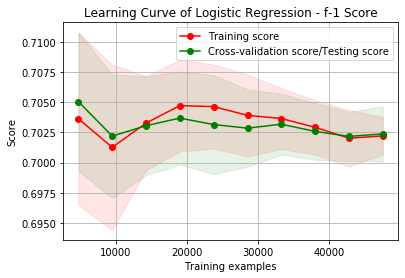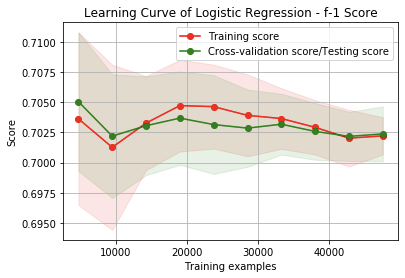

### Fitting curve

In [ ]:
############################### Import Libraries & Modules #################################

np.random.seed(42)  # the seed used by the random number generator for np

############################# Parameters - Varying Complexity #############################

# Specify possible parameter values
param_range = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]


# Determine training and test scores for varying parameter values.
train_scores, test_scores = validation_curve(
    estimator=estimator,  # Build Decision Trees
    X=X_train,
    y=y_train,
    param_name="C",  # parameter max depth
    param_range=param_range,
    cv=10,  # 10-fold cross-validation
    scoring="f1",
    n_jobs=8) 

# Cross validation statistics for training and testing data (mean and standard deviation)
# Compute the arithmetic mean along the specified axis.
train_mean = np.mean(train_scores, axis=1)
# Compute the standard deviation along the specified axis.
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot train accuracy means of cross-validation for all the parameters max_depth in param_range
plt.semilogx(param_range, train_mean,
             color='blue', marker='o',
             markersize=5, label='training accuracy')

# Fill the area around the line to indicate the size of standard deviations of performance for the training data
plt.fill_between(param_range, train_mean + train_std,
                 train_mean - train_std, alpha=0.15,
                 color='blue')

# Plot test accuracy means of cross-validation for all the parameters max_depth in param_range
plt.semilogx(param_range, test_mean,
             color='green', linestyle='--',
             marker='s', markersize=5,
             label='validation/test accuracy')

# Fill the area around the line to indicate the size of standard deviations of performance for the test data
plt.fill_between(param_range,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

# Grid and Axes Titles
plt.grid()
plt.legend(loc='lower right')
plt.xlabel('C')
plt.ylabel('Accuracy based on f-1 score')
# plt.ylim([0.95, 1.0]) # y limits in the plot
plt.tight_layout()
# plt.savefig('Fitting_graph_LR.png', dpi=300)
plt.show()           # Display the figure

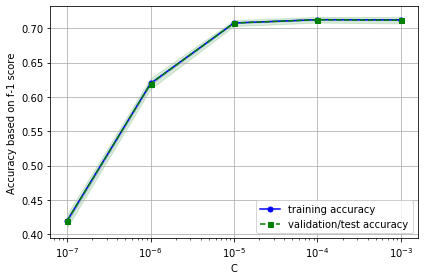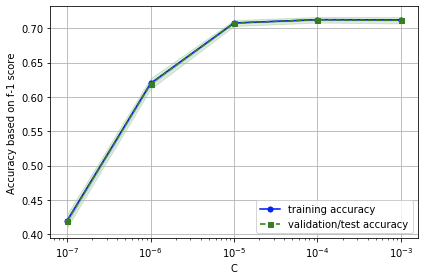

### Base Optimized Model

In [ ]:
# Logistic Regression - Parameter Tuning
gs_lr3 = GridSearchCV(estimator=LogisticRegression(random_state=42),
                      param_grid=[{'penalty': ['l1', 'l2'],
                                   'C': [1e-7, 1e-6, 1e-5, 1e-4, 1e-3],
                                   }],
                      scoring='f1',
                      cv=inner_cv,
                      n_jobs=-1)

gs_lr3 = gs_lr3.fit(X, y)
print(color.SET + "\nLogistic Regression - Parameter Tuning - Penalty and C" + color.END)
print("Non-nested CV f1: ", gs_lr3.best_score_)
print("Optimal Parameter: ", gs_lr3.best_params_)
print("Optimal Estimator: ", gs_lr3.best_estimator_)
nested_score_gs_lr3 = cross_val_score(gs_lr3, X=X, y=y, cv=outer_cv)
print("Nested CV f1:", nested_score_gs_lr3.mean(),
      " +/- ", nested_score_gs_lr3.std())

Logistic Regression - Parameter Tuning - Penalty and C<br>
Non-nested CV f1:  0.7125148349888346
Optimal Parameter:  {'C': 0.001, 'penalty': 'l1'}
Optimal Estimator:  LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=42, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
Nested CV f1: 0.7119024364831615  +/-  0.0033207986498625473

### Metrics

In [ ]:
estimator = gs_lr3.best_estimator_

y_pred = estimator.predict(X_test)
y_pred_insample = estimator.predict(X_train)

print('Accuracy (out-of-sample): %.2f' % accuracy_score(y_test, y_pred))
print('Accuracy (in-sample): %.2f' % accuracy_score(y_train, y_pred_insample))

# F1 score
print('F1 score (out-of-sample): ', f1_score(y_test, y_pred, average='macro'))
print('F1 score (in-sample)    : ',
      f1_score(y_train, y_pred_insample, average='macro'))

# Kappa score
print('Kappa score (out-of-sample): ', cohen_kappa_score(y_test, y_pred))
print('Kappa score (in-sample)    : ',
      cohen_kappa_score(y_train, y_pred_insample))

# Build a text report showing the main classification metrics (out-of-sample performance)
print(classification_report(y_test, y_pred, target_names=classifications))

Accuracy (out-of-sample): 0.71
Accuracy (in-sample): 0.72
F1 score (out-of-sample):  0.712186318772102
F1 score (in-sample)    :  0.7154982860992815
Kappa score (out-of-sample):  0.42439139132807313
Kappa score (in-sample)    :  0.43102868773100245
              precision    recall  f1-score   support

           1       0.71      0.72      0.71      8488
           0       0.71      0.71      0.71      8506

    accuracy                           0.71     16994
   macro avg       0.71      0.71      0.71     16994
weighted avg       0.71      0.71      0.71     16994


### Learning Curve

In [ ]:
########################### Visualization of Learning Curves ###########################
title = "Learning Curve of Logistic Regression - f-1 Score"

cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=42)
estimator = estimator
plot_learning_curve(estimator, title, X, y, cv=cv, n_jobs=8)

plt.show()

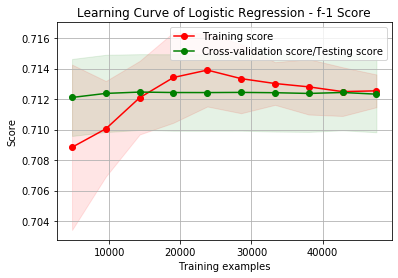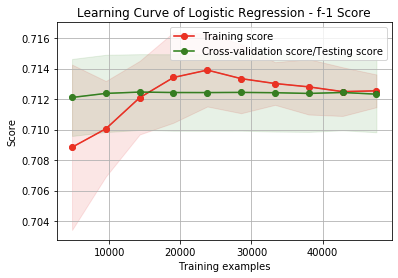

### Fitting Curve

In [ ]:
############################### Import Libraries & Modules #################################

np.random.seed(42)  # the seed used by the random number generator for np

############################# Parameters - Varying Complexity #############################

# Specify possible parameter values
param_range = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]


# Determine training and test scores for varying parameter values.
train_scores, test_scores = validation_curve(
    estimator=estimator,
    X=X_train,
    y=y_train,
    param_name="C",
    param_range=param_range,
    cv=10,
    scoring="f1",
    n_jobs=4)

# Compute the arithmetic mean along the specified axis.
train_mean = np.mean(train_scores, axis=1)
# Compute the standard deviation along the specified axis.
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

############################## Visualization - Fitting Graph ##############################

# Plot train accuracy means of cross-validation for all the parameters max_depth in param_range
plt.semilogx(param_range, train_mean,
             color='blue', marker='o',
             markersize=5, label='training accuracy')

# Fill the area around the line to indicate the size of standard deviations of performance for the training data
plt.fill_between(param_range, train_mean + train_std,
                 train_mean - train_std, alpha=0.15,
                 color='blue')

# Plot test accuracy means of cross-validation for all the parameters max_depth in param_range
plt.semilogx(param_range, test_mean,
             color='green', linestyle='--',
             marker='s', markersize=5,
             label='validation/test accuracy')

# Fill the area around the line to indicate the size of standard deviations of performance for the test data
plt.fill_between(param_range,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

# Grid and Axes Titles
plt.grid()
plt.legend(loc='lower right')
plt.xlabel('C')
plt.ylabel('Accuracy based on f-1 score')
# plt.ylim([0.95, 1.0]) # y limits in the plot
plt.tight_layout()
plt.show()           # Display the figure

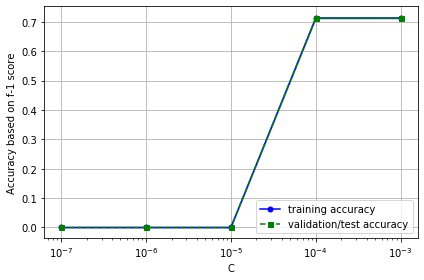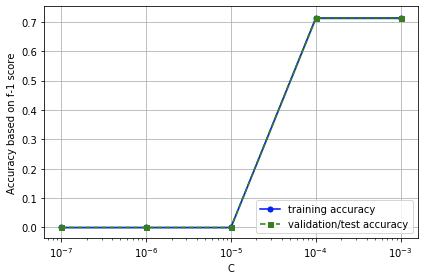

### Transformed Optimized Model

In [18]:
X = pd.read_csv('/Users/baixiao/Desktop/X_transformed.csv')
y = pd.read_csv('/Users/baixiao/Desktop/y_balance.csv')
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [ ]:
# Logistic Regression - Parameter Tuning
gs_lr3 = GridSearchCV(estimator=LogisticRegression(random_state=42),
                      param_grid=[{'penalty': ['l1', 'l2'],
                                   'C': [ 1e-7, 1e-6, 1e-5, 1e-4, 1e-3],
                                   }],
                      scoring='f1',
                      cv=inner_cv,
                      n_jobs=8)

gs_lr3 = gs_lr3.fit(X, y)
print(color.SET + "\nLogistic Regression - Parameter Tuning - Penalty and C" + color.END)
print("Non-nested CV f1: ", gs_lr3.best_score_)
print("Optimal Parameter: ", gs_lr3.best_params_)
print("Optimal Estimator: ", gs_lr3.best_estimator_)
nested_score_gs_lr3 = cross_val_score(gs_lr3, X=X, y=y, cv=outer_cv)
print("Nested CV f1:", nested_score_gs_lr3.mean(),
      " +/- ", nested_score_gs_lr3.std())

Logistic Regression - Parameter Tuning - Penalty and C
Non-nested CV f1:  0.7125342436071481
Optimal Parameter:  {'C': 0.001, 'penalty': 'l1'}
Optimal Estimator:  LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=42, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
Nested CV f1: 0.7120749976817567  +/-  0.0031682187286711473

### Metrics

In [ ]:
estimator = gs_lr3.best_estimator_

y_pred = estimator.predict(X_test)
y_pred_insample = estimator.predict(X_train)

print('Accuracy (out-of-sample): %.2f' % accuracy_score(y_test, y_pred))
print('Accuracy (in-sample): %.2f' % accuracy_score(y_train, y_pred_insample))

# F1 score
print('F1 score (out-of-sample): ', f1_score(y_test, y_pred, average='macro'))
print('F1 score (in-sample)    : ',
      f1_score(y_train, y_pred_insample, average='macro'))

# Kappa score
print('Kappa score (out-of-sample): ', cohen_kappa_score(y_test, y_pred))
print('Kappa score (in-sample)    : ',
      cohen_kappa_score(y_train, y_pred_insample))

# Build a text report showing the main classification metrics (out-of-sample performance)
print(classification_report(y_test, y_pred, target_names=classifications))

Accuracy (out-of-sample): 0.71
Accuracy (in-sample): 0.72
F1 score (out-of-sample):  0.7122450059115002
F1 score (in-sample)    :  0.7156545110892298
Kappa score (out-of-sample):  0.4245091503703403
Kappa score (in-sample)    :  0.43134247498793743
              precision    recall  f1-score   support

           1       0.71      0.72      0.71      8488
           0       0.72      0.71      0.71      8506

    accuracy                           0.71     16994
   macro avg       0.71      0.71      0.71     16994
weighted avg       0.71      0.71      0.71     16994

### Fitting Curve and Learning Curve

In [ ]:
########################### Visualization of Learning Curves ###########################
title = "Learning Curve of Logistic Regression - f-1 Score"

cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=42)
estimator = estimator
plot_learning_curve(estimator, title, X, y, cv=cv, n_jobs=8)

plt.show()

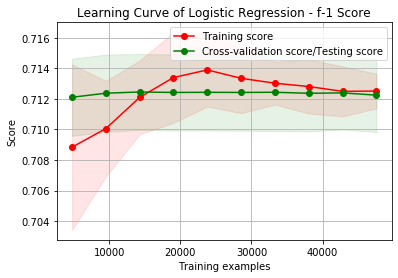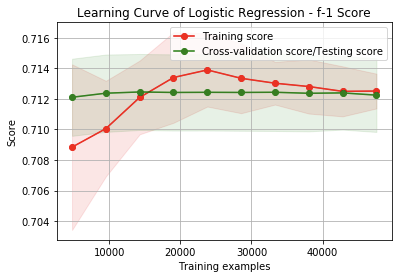

In [ ]:
############################### Import Libraries & Modules #################################

np.random.seed(42)  # the seed used by the random number generator for np

############################# Parameters - Varying Complexity #############################

# Specify possible parameter values
#param_range = [1e-7, 1e-5, 8e-5, 1e-4, 1e-3]
param_range = [1e-6, 1e-5, 5.2e-5, 5.3e-5, 5.4e-5, 5.5e-5, 1e-4, 1e-3]



# Determine training and test scores for varying parameter values.
train_scores, test_scores = validation_curve(
    estimator=estimator,
    X=X_train,
    y=y_train,
    param_name="C",
    param_range=param_range,
    cv=10,
    scoring="f1",
    n_jobs=4)

# Compute the arithmetic mean along the specified axis.
train_mean = np.mean(train_scores, axis=1)
# Compute the standard deviation along the specified axis.
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

############################## Visualization - Fitting Graph ##############################

# Plot train accuracy means of cross-validation for all the parameters max_depth in param_range
plt.semilogx(param_range, train_mean,
             color='blue', marker='o',
             markersize=5, label='training accuracy')

# Fill the area around the line to indicate the size of standard deviations of performance for the training data
plt.fill_between(param_range, train_mean + train_std,
                 train_mean - train_std, alpha=0.15,
                 color='blue')

# Plot test accuracy means of cross-validation for all the parameters max_depth in param_range
plt.semilogx(param_range, test_mean,
             color='green', linestyle='--',
             marker='s', markersize=5,
             label='validation/test accuracy')

# Fill the area around the line to indicate the size of standard deviations of performance for the test data
plt.fill_between(param_range,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

# Grid and Axes Titles
plt.grid()
plt.legend(loc='lower right')
plt.xlabel('C')
plt.ylabel('Accuracy based on f-1 score')
plt.tight_layout()
plt.show()           # Display the figure

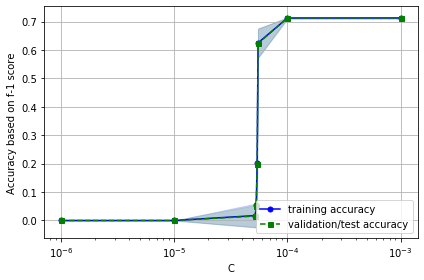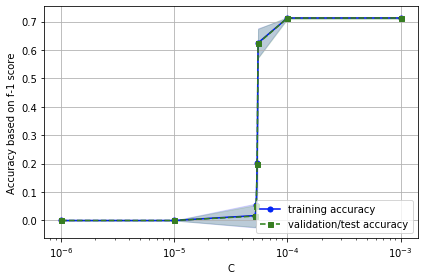

## Model Type III: k-Nearest-Neighbors Classification

In [ ]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score, cohen_kappa_score, f1_score, classification_report

from sklearn.model_selection import train_test_split
from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def warn(*args, **kwargs):
    """disable all warings"""
    pass


# overwrite system warning function
warnings.warn = warn
# print control

In [ ]:
np.random.seed(42)

In [ ]:
inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)

### Basic kNN Model

In [ ]:
X = pd.read_csv("X_balance.csv")
y = pd.read_csv("y_balance.csv")

X_train, X_test, y_train, y_test = train_test_split(X, y, #test_size=0.3, 
                                                    random_state=42)

In [19]:
# ***Standardization
from sklearn.preprocessing import StandardScaler 
sc = StandardScaler()
sc.fit(X) 
X_std = sc.transform(X)

sc.fit(X_train)
sc.fit(X_test)
X_train_std = sc.transform(X_train)       
X_test_std = sc.transform(X_test)

knn = neighbors.KNeighborsClassifier(n_neighbors=3,  p=2,  metric='minkowski') 
knn = knn.fit(X_train_std, y_train)  

NameError: name 'X_balance' is not defined

In [ ]:
y_pred = knn.predict(X_test_std)
y_pred_insample = knn.predict(X_train_std)

# Accuracy
print('Accuracy (out-of-sample): %.2f' % accuracy_score(y_test, y_pred))
print('Accuracy (in-sample): %.2f' % accuracy_score(y_train, y_pred_insample))

# F1 score
print('F1 score (out-of-sample): ', f1_score(y_test, y_pred, average='macro'))
print('F1 score (in-sample)    : ', f1_score(y_train, y_pred_insample, average='macro'))

# Build a text report showing the main classification metrics (out-of-sample performance)
print(classification_report(y_test, y_pred))

Accuracy (out-of-sample): 0.89
Accuracy (in-sample): 0.94
F1 score (out-of-sample):  0.893595076569042
F1 score (in-sample)    :  0.9432591846601532
              precision    recall  f1-score   support

           0       0.98      0.80      0.88     10188
           1       0.83      0.98      0.90     10205

    accuracy                           0.89     20393
   macro avg       0.91      0.89      0.89     20393
weighted avg       0.91      0.89      0.89     20393


### Learning Curve

In [ ]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)): # np.linspace(.1, 1.0, 5) will return evenly
                                                                        # spaced 5 numbers from 0.1 to 1.0
    
    # Visualization patamters
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    # Estimate train and test score for different training set sizes
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes) 
                                                                        
                                                                        

    # Estimate statistics of train and test scores (mean, std)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    # Fill the area around the mean scores with standard deviation info
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r") # Fill for train set scores

    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")  # Fill for test set scores
    
    # Visualization parameters that will allow us to distinguish train set scores from test set scores
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [ ]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn import neighbors

title = "Learning Curve (kNN)"
cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=42)
knn = neighbors.KNeighborsClassifier(n_neighbors = 3, p=2,  metric='minkowski') 
plot_learning_curve(knn, title, X_std, y_balance,  (0.0, 1.01), cv=cv, n_jobs=7)

plt.show()

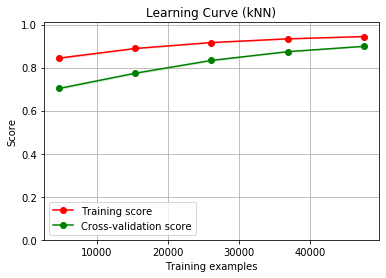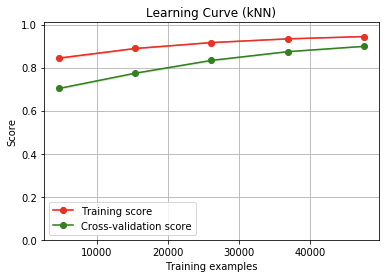

### Fitting Curve

In [ ]:
from sklearn.model_selection import validation_curve

param_range = [3, 5, 7, 9, 11, 13, 15]
train_scores, test_scores = validation_curve(estimator = neighbors.KNeighborsClassifier(p=2, metric = "minkowski"),
 X=X_train_std, y=y_pred_insample, param_name="n_neighbors", param_range=param_range, cv = 10, scoring='f1', n_jobs=4)

train_mean = np.mean(train_scores, axis=1) 
train_std = np.std(train_scores, axis=1)  
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean, color='blue', marker='o', markersize=5, label='Training Score')

plt.fill_between(param_range, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')

plt.plot(param_range, test_mean, color='green', linestyle='--', marker='s', markersize=5,label='Validation Score')

plt.fill_between(param_range, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

plt.grid()
plt.legend(loc='lower left')
plt.xlabel('Number of Neighbors')
plt.title('Fitting Graph')
plt.ylabel('f1')
plt.tight_layout()
plt.show()

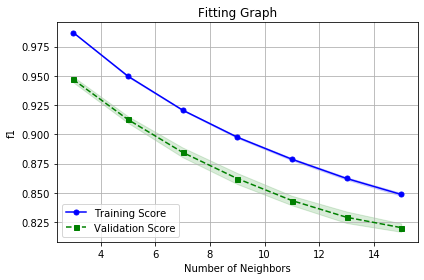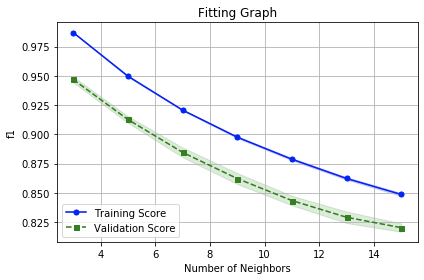

### Base Optimized Model

In [ ]:
opt_knn = GridSearchCV(estimator=neighbors.KNeighborsClassifier(metric='minkowski'), 
    param_grid=[{'n_neighbors': [3,5,7,9,11,13,15], 'weights':['uniform','distance'], 'p':[1, 2]}],
    scoring='f1', cv=inner_cv, n_jobs = 4)

opt_knn = opt_knn.fit(X_std ,y_balance) 
print("\n Parameter Tuning")
print("Non-nested CV f1: ", opt_knn.best_score_)
print("Optimal Parameter: ", opt_knn.best_params_)
print("Optimal Estimator: ", opt_knn.best_estimator_)
nested_score_opt_knn = cross_val_score(opt_knn, X=X_std, y=y_balance, cv=outer_cv)
print("Nested CV f1: ",nested_score_opt_knn.mean(), " +/- ", nested_score_opt_knn.std())

Parameter Tuning
Non-nested CV f1:  0.924627051158157
Optimal Parameter:  {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
Optimal Estimator:  KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=1,
                     weights='distance')
Nested CV f1:  0.9241512824406785  +/-  0.0012833274629558433

### Metrics

In [ ]:
#best estimator found during tuning
knn_opt = neighbors.KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=1,
                     weights='distance')
knn_opt = knn_opt.fit(X_train_std, y_train)

y_pred_opt = knn_opt.predict(X_test_std)
y_pred_insample_opt = knn_opt.predict(X_train_std)

# Accuracy
print('Accuracy (out-of-sample): %.2f' % accuracy_score(y_test, y_pred_opt))
print('Accuracy (in-sample): %.2f' % accuracy_score(y_train, y_pred_insample_opt))

# F1 score
print('F1 score (out-of-sample): ', f1_score(y_test, y_pred_opt, average='macro'))
print('F1 score (in-sample)    : ', f1_score(y_train, y_pred_insample_opt, average='macro'))

# Build a text report showing the main classification metrics (out-of-sample performance)
print(classification_report(y_test, y_pred_opt))

Accuracy (out-of-sample): 0.91
Accuracy (in-sample): 1.00
F1 score (out-of-sample):  0.9091105176721648
F1 score (in-sample)    :  0.9955023549271698
              precision    recall  f1-score   support

           0       0.99      0.83      0.90     10188
           1       0.85      0.99      0.92     10205

    accuracy                           0.91     20393
   macro avg       0.92      0.91      0.91     20393
weighted avg       0.92      0.91      0.91     20393

### Learning Curve

In [ ]:
title = "Optimized Learning Curve (kNN)"
cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=42)
plot_learning_curve(knn_opt, title, X_std, y_balance,  (0.0, 1.01), cv=cv, n_jobs=7)

plt.show()

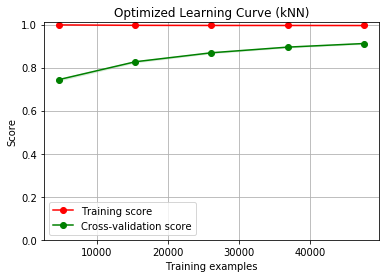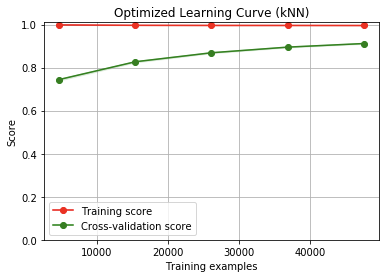

### Fitting Curve

In [ ]:
param_range = [1, 3, 5, 7, 9, 11, 13, 15]
train_scores, test_scores = validation_curve(estimator = neighbors.KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, p=1,
                     weights='distance'),
 X=X_train_std, y=y_pred_insample_opt, param_name="n_neighbors", param_range=param_range, cv = 10, scoring='f1', n_jobs=4)

train_mean = np.mean(train_scores, axis=1) 
train_std = np.std(train_scores, axis=1)  
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean, color='blue', marker='o', markersize=5, label='Training Score')

plt.fill_between(param_range, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')

plt.plot(param_range, test_mean, color='green', linestyle='--', marker='s', markersize=5,label='Validation Score')

plt.fill_between(param_range, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

plt.grid()
plt.legend(loc='lower left')
plt.xlabel('Number of Neighbors')
plt.title('Optimized Fitting Graph')
plt.ylabel('f1')
plt.tight_layout()
plt.show()

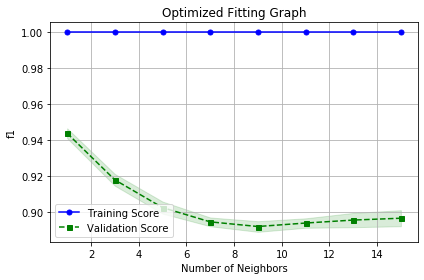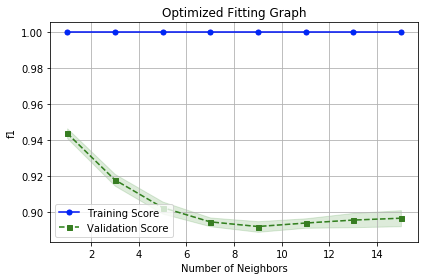

### Transformed Optimized Model

In [ ]:
X_transformed = pd.read_csv("X_transformed.csv")
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y_balance, #test_size=0.3, 
                                                    random_state=42)

In [20]:
# ***Standardization
sc = StandardScaler()
sc.fit(X_transformed) 
X_tr_std = sc.transform(X_transformed)

sc.fit(X_train)
sc.fit(X_test)            #?????Problematic???
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

NameError: name 'X_transformed' is not defined

In [ ]:
tr_knn = GridSearchCV(estimator=neighbors.KNeighborsClassifier(metric='minkowski'), 
    param_grid=[{'n_neighbors': [3,5,7,9,11,13,15], 'weights':['uniform','distance'], 'p':[1, 2]}],
    scoring='f1', cv=inner_cv, n_jobs = 4)

tr_knn = tr_knn.fit(X_tr_std ,y_balance) 
print("\n Parameter Tuning")
print("Non-nested CV f1: ", tr_knn.best_score_)
print("Optimal Parameter: ", tr_knn.best_params_)
print("Optimal Estimator: ", tr_knn.best_estimator_)
nested_score_tr_knn = cross_val_score(tr_knn, X=X_tr_std, y=y_balance, cv=outer_cv)
print("Nested CV f1: ",nested_score_tr_knn.mean(), " +/- ", nested_score_tr_knn.std())

Parameter Tuning
Non-nested CV f1:  0.925409737700338
Optimal Parameter:  {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
Optimal Estimator:  KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=1,
                     weights='distance')
Nested CV f1:  0.9254097596296372  +/-  0.001775138837325355

### Metrics

In [ ]:
knn_tr = neighbors.KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=1, weights='distance')
knn_tr = knn_tr.fit(X_train_std, y_train) 

y_pred_tr = knn_tr.predict(X_test_std)
y_pred_insample_tr = knn_tr.predict(X_train_std)

In [ ]:
# Accuracy
print('Accuracy (out-of-sample): %.2f' % accuracy_score(y_test, y_pred_tr))
print('Accuracy (in-sample): %.2f' % accuracy_score(y_train, y_pred_insample_tr))

# F1 score
print('F1 score (out-of-sample): ', f1_score(y_test, y_pred_tr, average='macro'))
print('F1 score (in-sample)    : ', f1_score(y_train, y_pred_insample_tr, average='macro'))

# Build a text report showing the main classification metrics (out-of-sample performance)
print(classification_report(y_test, y_pred_tr))

Accuracy (out-of-sample): 0.91
Accuracy (in-sample): 1.00
F1 score (out-of-sample):  0.9096211462899034
F1 score (in-sample)    :  0.9954603258981869
              precision    recall  f1-score   support

           0       0.99      0.83      0.90     10188
           1       0.85      0.99      0.92     10205

    accuracy                           0.91     20393
   macro avg       0.92      0.91      0.91     20393
weighted avg       0.92      0.91      0.91     20393

### Fitting Curve and Learning Curve

In [ ]:
title = "Transformed and Optimized Learning Curve (kNN)"
cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=42)
plot_learning_curve(knn_tr, title, X_tr_std, y_balance,  (0.0, 1.01), cv=cv, n_jobs=7)

plt.show()

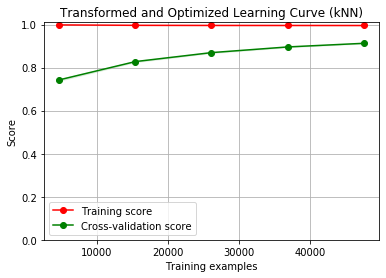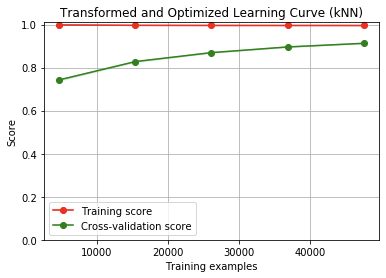

In [ ]:
param_range = [3, 5, 7, 9, 11, 13, 15]
train_scores, test_scores = validation_curve(estimator = knn_tr, X=X_train_std, y=y_pred_insample_tr,
param_name="n_neighbors", param_range=param_range, cv = 10, scoring='f1', n_jobs=4)

train_mean = np.mean(train_scores, axis=1) 
train_std = np.std(train_scores, axis=1)  
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean, color='blue', marker='o', markersize=5, label='Training Score')

plt.fill_between(param_range, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')

plt.plot(param_range, test_mean, color='green', linestyle='--', marker='s', markersize=5,label='Validation Score')

plt.fill_between(param_range, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

plt.grid()
plt.legend(loc='lower left')
plt.xlabel('Number of Neighbors')
plt.title('Transformed and Optimized Fitting Graph')
plt.ylabel('f1')
plt.tight_layout()
plt.show()

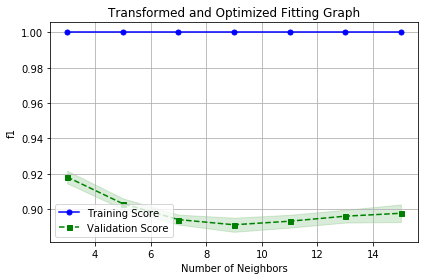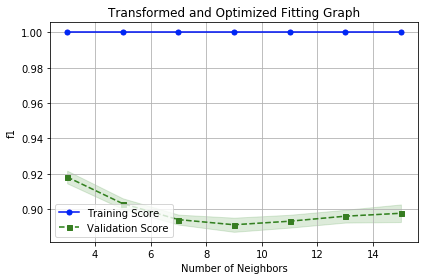

### ROC Curve & AUC for the Best models (in each stage)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import interp      #for interpolation for plotting

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.metrics import auc
from sklearn.model_selection import KFold

def warn(*args, **kwargs):
    """disable all warings"""
    pass


# overwrite system warning function
import warnings
warnings.warn = warn

In [2]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

In [3]:
X = pd.read_csv("/Users/baixiao/Desktop/X_balance.csv")
y = pd.read_csv("/Users/baixiao/Desktop/y_balance.csv")

In [4]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X)
X_std = sc.transform(X)

In [5]:
y = np.array(y)

#### Basic Models

For the Basic models, we have: <br>
-DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best') <br>
-KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=3, p=2,
           weights='uniform') <br>
-LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False) <br>

In [6]:
model1 = DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None, max_features=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, presort=False, random_state=42, splitter='best') 
model2 = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', metric_params=None, n_jobs=None, n_neighbors=3, p=2, weights='uniform') 
model3 = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True, intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=None, penalty='l2', random_state=42, solver='warn', tol=0.0001, verbose=0, warm_start=False) 

model_labels=['Decision Tree', 'kNN', 'Logistic Regression']
all_models = [model1, model2, model3]

In [7]:
print("5-fold shuffled cross validation:")
print()

for model, label in zip(all_models, model_labels):
    scores = cross_val_score(estimator=model, X=X_std, y=y, cv=cv, scoring="roc_auc")
    print("ROC AUC: %0.4f (+/- %0.4f) [%s]" % (scores.mean(), scores.std(), label))

5-fold shuffled cross validation:

ROC AUC: 0.9459 (+/- 0.0024) [Decision Tree]
ROC AUC: 0.9464 (+/- 0.0018) [kNN]
ROC AUC: 0.7856 (+/- 0.0035) [Logistic Regression]


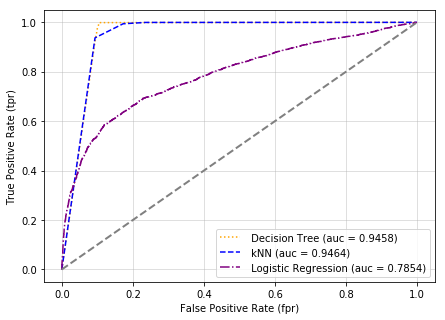

In [9]:
cv_ind = list(cv.split(X_std, y))
mean_fpr = np.linspace(0,1,100)    #x-axis plot initialization

fig = plt.figure(figsize=(7,5))
colors = ['orange', 'blue', 'purple']
linestyles = [':', '--', '-.']
for model, label, color, ls in zip(all_models, model_labels, colors, linestyles):
    mean_tpr = 0.0
    for i, (train, test) in enumerate(cv_ind):         #**running through each cv fold!
        probas = model.fit(X_std[train], y[train]).predict_proba(X_std[test])
        fpr, tpr, thresholds = roc_curve(y[test], probas[:, 1], pos_label=1)
        mean_tpr += interp(mean_fpr, fpr, tpr)     #**interpolate tpr values with fprs already specified initially
    mean_tpr = mean_tpr/len(cv_ind)     #average tpr over all folds
    mean_tpr[-1] = 1.0            #initializaton of mean tpr of "1"
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(fpr, tpr, color=color, linestyle=ls, label=" %s (auc = %.4f)" % (label, mean_auc))

plt.legend(loc='lower right')
plt.plot([0,1], [0,1], linestyle='--', color='gray', linewidth=2)
#plt.xlim([-0.1, 1,1])
#plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel("False Positive Rate (fpr)")
plt.ylabel("True Positive Rate (tpr)")
plt.show()

Regarding ROC-AUC, probably "kNN".

#### Basic Optimized Models

For the Basic Optimized models, we have: <br>
-DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=38,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best') <br>
-KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=1,
                     weights='distance') <br>
-LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=42, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False) <br>

In [10]:
model1 = DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=38, max_features=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=1, min_samples_split=10, min_weight_fraction_leaf=0.0, presort=False, random_state=42, splitter='best') 
model2 = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', metric_params=None, n_jobs=None, n_neighbors=3, p=1, weights='distance') 
model3 = LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True, intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=None, penalty='l1', random_state=42, solver='warn', tol=0.0001, verbose=0, warm_start=False)

model_labels=['Decision Tree', 'kNN', 'Logistic Regression']
all_models = [model1, model2, model3]

In [11]:
print("5-fold shuffled cross validation:")
print()

for model, label in zip(all_models, model_labels):
    scores = cross_val_score(estimator=model, X=X_std, y=y, cv=cv, scoring="roc_auc")
    print("ROC AUC: %0.4f (+/- %0.4f) [%s]" % (scores.mean(), scores.std(), label))

5-fold shuffled cross validation:

ROC AUC: 0.9447 (+/- 0.0027) [Decision Tree]
ROC AUC: 0.9495 (+/- 0.0016) [kNN]
ROC AUC: 0.7740 (+/- 0.0034) [Logistic Regression]


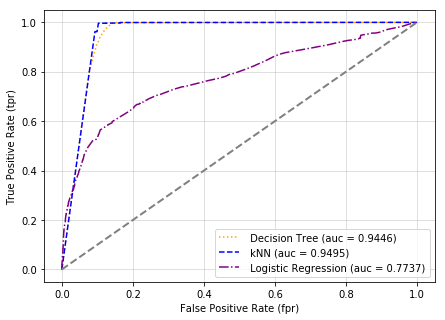

In [12]:
cv_ind = list(cv.split(X_std, y))      #[***] just use the previous "cv" in last model!
mean_fpr = np.linspace(0,1,100)    #x-axis plot initialization

fig = plt.figure(figsize=(7,5))
colors = ['orange', 'blue', 'purple']
linestyles = [':', '--', '-.']
for model, label, color, ls in zip(all_models, model_labels, colors, linestyles):
    mean_tpr = 0.0
    for i, (train, test) in enumerate(cv_ind):         #**running through each cv fold!
        probas = model.fit(X_std[train], y[train]).predict_proba(X_std[test])
        fpr, tpr, thresholds = roc_curve(y[test], probas[:, 1], pos_label=1)
        mean_tpr += interp(mean_fpr, fpr, tpr)     #**interpolate tpr values with fprs already specified initially
    mean_tpr = mean_tpr/len(cv_ind)     #average tpr over all folds
    mean_tpr[-1] = 1.0            #initializaton of mean tpr of "1"
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(fpr, tpr, color=color, linestyle=ls, label=" %s (auc = %.4f)" % (label, mean_auc))

plt.legend(loc='lower right')
plt.plot([0,1], [0,1], linestyle='--', color='gray', linewidth=2)
#plt.xlim([-0.1, 1,1])
#plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel("False Positive Rate (fpr)")
plt.ylabel("True Positive Rate (tpr)")
plt.show()

Regardig ROC-AUC, probably "kNN".

#### Transformed Data Optimized Models

For the Transformed data Optimized models, we have: <br>
-DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=36,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best') <br>
-KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=1,
                     weights='distance') <br>
-LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=42, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False) <br>

In [13]:
model1 = DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=36,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')
model2 = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=1,
                     weights='distance')
model3 = LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=42, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

model_labels=['Decision Tree', 'kNN', 'Logistic Regression']
all_models = [model1, model2, model3]

In [14]:
print("5-fold shuffled cross validation:")
print()

for model, label in zip(all_models, model_labels):
    scores = cross_val_score(estimator=model, X=X_std, y=y, cv=cv, scoring="roc_auc")
    print("ROC AUC: %0.4f (+/- %0.4f) [%s]" % (scores.mean(), scores.std(), label))

5-fold shuffled cross validation:

ROC AUC: 0.9445 (+/- 0.0027) [Decision Tree]
ROC AUC: 0.9495 (+/- 0.0016) [kNN]
ROC AUC: 0.7740 (+/- 0.0034) [Logistic Regression]


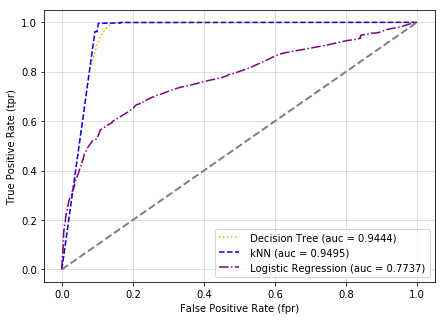

In [15]:
y = np.array(y)

cv_ind = list(cv.split(X_std, y))
mean_fpr = np.linspace(0,1,100)    #x-axis plot initialization

fig = plt.figure(figsize=(7,5))
colors = ['orange', 'blue', 'purple']
linestyles = [':', '--', '-.']
for model, label, color, ls in zip(all_models, model_labels, colors, linestyles):
    mean_tpr = 0.0
    for i, (train, test) in enumerate(cv_ind):         #**running through each cv fold!
        probas = model.fit(X_std[train], y[train]).predict_proba(X_std[test])
        fpr, tpr, thresholds = roc_curve(y[test], probas[:, 1], pos_label=1)
        mean_tpr += interp(mean_fpr, fpr, tpr)     #**interpolate tpr values with fprs already specified initially
    mean_tpr = mean_tpr/len(cv_ind)     #average tpr over all folds
    mean_tpr[-1] = 1.0            #initializaton of mean tpr of "1"
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(fpr, tpr, color=color, linestyle=ls, label=" %s (auc = %.4f)" % (label, mean_auc))

plt.legend(loc='lower right')
plt.plot([0,1], [0,1], linestyle='--', color='gray', linewidth=2)
#plt.xlim([-0.1, 1,1])
#plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel("False Positive Rate (fpr)")
plt.ylabel("True Positive Rate (tpr)")
plt.show()

Regarding ROC-AUC, probably kNN.

##### Overall, in conclusion, basic optimized and transformed-data optimized Decision Tree & kNN both have very closely strong performances (above 94%) in F1-score, Accuracy and ROC-AUC. There's very little difference in performance of basic optimized version and transformed-data optimized version of these two models. Decision Tree does a little better in F1-score and Accuracy, and kNN may a very slight advantage in ROC-AUC. Since we are using F1-score as our main goal of model evaluation, and transformed data helps aligned with the ideal normal distribution better, we would finally choose transformed-data optimized version of Deicison Tree(Classification Tree) as our final choice of model here. Furthermore, Classification Tree would provide us with good interpretability and insights about the reality for prediction, by revealing a set of rules to consider when purposefully designing which customers to target as well how and when to reach out to them. We would have a look at the visualizaition of the structure of our final tree model here to get better understanding:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
X = pd.read_csv("/Users/baixiao/Desktop/X_balance.csv")
y = pd.read_csv("/Users/baixiao/Desktop/y_balance.csv")

In [3]:
X.head()
y.head()
type(X)
type(y)

pandas.core.frame.DataFrame

In [4]:
from sklearn.tree import export_graphviz
from IPython.display import Image
from sklearn.externals.six import StringIO
import pydotplus
import os

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
#***Warning: mimic the optimized tree below, but for VISUALIZATION PURPOSE, limit the depth of tree to 5
final = DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=36,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
final.fit(X_train, y_train)

dot_data = StringIO()
export_graphviz(final, out_file=dot_data, filled=True, rounded = True, 
                special_characters=True, feature_names=list(X_train.columns),
                class_names =['No', 'Yes']
               )
graph=pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

In [ ]:
def image_path(fig_id):
    return os.path.join("/Users/baixiao/Desktop", fig_id)

def save_fig(fig_id, tight_layout=True):
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(image_path(fig_id) + ".png", format='png', dpi=300)

In [ ]:
export_graphviz(
        final,
        out_file=image_path("project_tree.dot"),
        feature_names=X_train.columns,
        class_names=['No', 'Yes'],
        rounded=True,
        filled=True
    )


***** IMPORTANT!!!!!: 
Every time, Converting .dot file to PNG Example: Run command "dot -Tpng iris_tree.dot -o iris_tree.png" in the terminal after installing graphviz package 
and making sure you are in the right directory (same directory as the .dot file)

Display our final model result again (using manual training-testing split)

#### Confusion Matrix

In [5]:
X = pd.read_csv("/Users/baixiao/Desktop/X_transformed.csv")  
y = pd.read_csv("/Users/baixiao/Desktop/y_balance.csv")

import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report, cohen_kappa_score, matthews_corrcoef
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
np.random.seed(42)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

final = DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=36,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')
final.fit(X_train, y_train)
y_pred_train = final.predict(X_train)
y_pred_test = final.predict(X_test)
confusion = confusion_matrix(y_test, y_pred_test)
print("The Confusion Matrix:")
print(confusion)

The Confusion Matrix:
[[7321 1167]
 [ 317 8189]]


In [6]:
# Plot Confusion Matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)     #print calculated confusion matrix

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[7321 1167]
 [ 317 8189]]


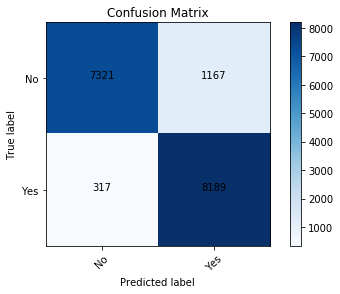

In [7]:
plt.figure()
plot_confusion_matrix(confusion, classes=["No", "Yes"], normalize=False, title="Confusion Matrix")
plt.show()

#### Main Evaluation Metrics

In [8]:
#Accuracy score
print("In-sample Accuracy: %.4f" % accuracy_score(y_train, y_pred_train))
print("Out-of-sample Accuracy: %.4f" % accuracy_score(y_test, y_pred_test))

#Classification Error
print("Predictive Error Rate(Out-of-sample): %.4f" % (1-accuracy_score(y_test, y_pred_test)))

#Summary Report on the main classification metrics for Out-of-sample performance
print("Classification report:")
print(classification_report(y_test, y_pred_test, target_names = ["0", "1"], digits=4))      #"digits" parameter of "classification_report()" function to specify number of digits to display the score outputs

#F1 score
print("In-sample F1 score: %.4f" % f1_score(y_train, y_pred_train, average='macro'))
print("Out-of-sample F1 score: %.4f" % f1_score(y_test, y_pred_test, average="macro"))

#Matthews Correlation Coefficient
print("In-sample Matthews Correlation Coefficient: %.4f" % matthews_corrcoef(y_train, y_pred_train))
print("Out-of-sample Matthews Correlation Coefficient: %.4f" % matthews_corrcoef(y_test, y_pred_test))

#Cohen's Kappa Coefficient
print("In-sample Cohen's Kappa Coefficient: %.4f" % cohen_kappa_score(y_train, y_pred_train))
print("Out-of-sample Cohen's Kappa Coefficient: %.4f" % matthews_corrcoef(y_test, y_pred_test))

In-sample Accuracy: 0.9705
Out-of-sample Accuracy: 0.9127
Predictive Error Rate(Out-of-sample): 0.0873
Classification report:
              precision    recall  f1-score   support

           0     0.9585    0.8625    0.9080      8488
           1     0.8753    0.9627    0.9169      8506

   micro avg     0.9127    0.9127    0.9127     16994
   macro avg     0.9169    0.9126    0.9124     16994
weighted avg     0.9168    0.9127    0.9125     16994

In-sample F1 score: 0.9705
Out-of-sample F1 score: 0.9124
In-sample Matthews Correlation Coefficient: 0.9413
Out-of-sample Matthews Correlation Coefficient: 0.8295
In-sample Cohen's Kappa Coefficient: 0.9410
Out-of-sample Cohen's Kappa Coefficient: 0.8295


### Feature Importance

In [9]:
#[use "X_train", "y_train" etc. in last 'display result of final model' section]

In [10]:
#F_value and p-value
from sklearn.feature_selection import f_classif
f_values, p_values = f_classif(X_train, y_train)
#print(f_values)
for i in range(len(X_train.columns)):
    #print(i)
    #print(X_train.columns[i])
    #print(f_values[i])
    print(X_train.columns[i], ":", f_values[i])
print()
print(sorted(f_values, reverse=True))

age : 106.21207896740248
campaign : 789.8115138566598
pdays : 3864.629705980206
previous : 3541.25309589767
emp.var.rate : 11442.486281286172
cons.price.idx : 2058.641709092077
cons.conf.idx : 294.69436863889916
euribor3m : 12481.370529199274
nr.employed : 13926.819595470128
job_encoded : 52.216378569489244
marital_encoded : 214.32113003028877
education_encoded : 338.07113176260435
housing_encoded : 21.462647079793253
loan_encoded : 15.874140171796233
contact_encoded : 3275.898076193716
month_encoded : 3.2251266276783097
dayofweek_encoded : 39.14845411537409
poutcome_encoded : 1461.5484069641873
age_log : 5.391730758192583
campaign_log : 665.3463658400135
pdays_log : 4993.158972959101
previous_log : 3814.169014018948
cons.price.idx_trans : 2322.757388213528
job_encoded_log : 30.083047706837394
housing_encoded_log : 21.462647079519673
loan_encoded_log : 15.874140171537531
contact_encoded_log : 3275.898076168479

[13926.819595470128, 12481.370529199274, 11442.486281286172, 4993.158972959

/anaconda3/envs/IntroToBA_Project/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Exploring the clustering(natural group) of potential customers based on K-means

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import KMeans

In [12]:
#***We are using customers' demographical information as the data here
# 'age', 'job', 'marital', 'education', 'housing', 'loan'
X = pd.read_csv("/Users/baixiao/Desktop/X_dummy_unbalanced.csv")
X = X[['age', 'housing', 'loan', 'admin.', 'blue-collar', 'entrepreneur', 
       'housemaid', 'management','retired','self-employed','services','student',
      'technician', 'divorced', 'married', 'basic.4y', 'basic.6y', 'basic.9y', 
      'high.school', 'illiterate', 'professional.course']]
y = pd.read_csv("/Users/baixiao/Desktop/y.csv")
#X.head()
#y.shape
#y.dtypes

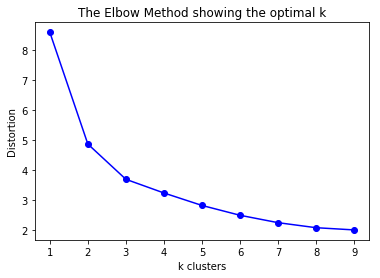

In [13]:
# Elbow method
from scipy.spatial.distance import cdist

distortions=[]
K = range(1,10)
for i in K:
    kmean = KMeans(n_clusters=i).fit(X)
    kmean.fit(X)
    distortions.append(sum(np.min(cdist(X, kmean.cluster_centers_, 'euclidean'), axis=1))/X.shape[0])
    
#Plot the elbow
plt.plot(K, distortions, 'bo-')
plt.xlabel("k clusters")
plt.ylabel("Distortion")
plt.title("The Elbow Method showing the optimal k")
plt.show()

In [14]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters = 2)
kmeans.fit(X)
group_kmeans = kmeans.predict(X)

#print the centers of each group
centers = kmeans.cluster_centers_
print(X.columns)
print(np.round_(centers, decimals=1))
#print(np.round_(centers, decimals=2))
print(group_kmeans)
#print(group_kmeans[group_kmeans==0].shape)
#print(group_kmeans[group_kmeans==1])
#print(y[group_kmeans==0].sum())
print("Percentage of 'yes' for group 1:")
print((y[group_kmeans==0].sum())/len(group_kmeans[group_kmeans==0]))
print("Percentage of 'yes' for group 2:")
print((y[group_kmeans==1].sum())/len(group_kmeans[group_kmeans==1]))

Index(['age', 'housing', 'loan', 'admin.', 'blue-collar', 'entrepreneur',
       'housemaid', 'management', 'retired', 'self-employed', 'services',
       'student', 'technician', 'divorced', 'married', 'basic.4y', 'basic.6y',
       'basic.9y', 'high.school', 'illiterate', 'professional.course'],
      dtype='object')
[[33.5  0.5  0.2  0.3  0.2  0.   0.   0.1  0.   0.   0.1  0.   0.2  0.1
   0.5  0.1  0.1  0.2  0.3  0.   0.1]
 [51.3  0.5  0.2  0.2  0.2  0.   0.   0.1  0.1  0.   0.1 -0.   0.1  0.2
   0.7  0.2  0.1  0.1  0.2  0.   0.1]]
[1 1 0 ... 1 1 1]
Percentage of 'yes' for group 1:
y    0.11024
dtype: float64
Percentage of 'yes' for group 2:
y    0.113311
dtype: float64
